# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from utils import cluster_scatter_plot_2D
from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
# from google.colab import drive
# drive.mount('/content/drive')
import pickle

## 1.1 Φόρτωση των δεδομένων
Φορτώνουμε τα δεδομένα από το αρχείο `movies.xlsx` σε ένα pandas dataframe.

In [2]:
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

In [3]:
df = pd.read_excel('movies.xlsx')
last_idx = len(df) - 1

df_un_orig = pd.read_excel('movies_test_anon.xlsx')
# df_unkwn = pd.read_excel('movies_test_anon_sample.xlsx')

# Concat two dataframes
df = pd.concat([df, df_un_orig.drop(['ID'], axis=1)])

Μετονομάζουμε τις στήλες σε πιο χρήσιμα ονόματα αφαιρώντας τα επιπλέον κενά. 

In [4]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df_unkwn_unkwn_unkwn_unkwn columns
df = df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων
Βλέπουμε το περιεχόμενο του dataframe εμφανίζοντας τις πρώτες 5 γραμμές.

In [5]:
# split
df_un = df.iloc[last_idx+1:]
df = df.iloc[:last_idx+1]

Τα βασικά χαρακτηριστικά του dataframe όπως τον αριθμό των γραμμών και τον τύπο των δεδομένων της κάθε στήλης.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   object 
 

Βασικά στατιστικά των στηλών που περιλαμβάνων αριθμητικούς τύπους δεδομένων όπως τη μέση τιμή και τη κανονική κατανομή.  

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1402.0,2012.140514,3.190291,2007.0,2009.0,2012.0,2015.0,2017.0
rotten_tomatoes_audience,1401.0,62.122769,17.435737,17.0,49.0,62.0,76.0,98.0
imdb_rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_vs_rt_disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Κάποιες επιπλέον ιδιότητες του dataframe συμπεριλαμβανομένου και του τύπου δεδομένων `object`

In [8]:
df.describe(include='object').T

,count,unique,top,freq
film,1402,1396,Big Miracle,2
script_type,1402,17,original screenplay,546
rotten_tomatoes_critics,1401,102,93,29
metacritic_critics,1402,90,51,39
average_critics,1402,196,64,25
metacritic_audience,1402,78,66,50
rotten_tomatoes_vs_metacritic_deviance,1402,82,-1,58
average_audience,1402,116,58,45
audience_vs_critics_deviance,1402,78,-5,54
...,...,...,...,...


# 2. Καθάρισμα δεδομένων
Ελέγχουμε και αντιμετωπίζουμε **missing values**, **outliers** και **διπλότυπα**.


## 2.1 Έλεγχος για διπλότυπα

Ελέγχουμε για διπλότυπα με το όνομα της ταινίας.

In [9]:
df[df.duplicated(subset=['film'], keep=False)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.0,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.0,36931089,37.0,20.79,20788004,57719093,58.0,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.0,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.0,20157300,20.0,4.56,4561915,24719215,25.0,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.0,20275446,20.0,10.81,10808153,31083599,31.0,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.0,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.0,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.0,16377274,16.0,11.88,11880786,28258060,28.0,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.0,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.9,41.80,41800000,102700477,103.0,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

## 2.2 Απών τιμές
Ελέγχουμε για τυχών απών τιμές όπως `NaN` και `-`.

In [10]:
#Concat
df = pd.concat([df, df_un])

Μετατροπή άκυρων τιμών σε NaN

In [11]:
# replace white characters with NaN
df = df.replace(r'^-$', np.nan, regex=True)
#Count NaN values per column
df.isna().sum()

film                                         0
year                                         0
script_type                                193
rotten_tomatoes_critics                      6
metacritic_critics                          18
average_critics                             12
rotten_tomatoes_audience                     1
metacritic_audience                         19
rotten_tomatoes_vs_metacritic_deviance      19
average_audience                            11
audience_vs_critics_deviance                16
primary_genre                             1689
                                          ... 
worldwide_gross                             23
worldwide_gross_($million)                  22
of_gross_earned_abroad                     132
budget_($million)                           74
budget_recovered                            92
budget_recovered_opening_weekend            88
distributor                               1562
imdb_rating                               1405
imdb_vs_rt_di

Μετατροπή σε αριθμητικά

In [12]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('#VALUE!','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)

Υπολογισμός NaN τιμών από άλλες τιμές όπου είναι εφικτό

In [13]:
df['metacritic_critics'] = df.apply(lambda row: row['average_critics'] * 2 - row['rotten_tomatoes_critics'] if pd.isnull(row['metacritic_critics']) and pd.notnull(row['average_critics']) else row['metacritic_critics'], axis=1)
df['average_critics'] = df.apply(lambda row: (row['rotten_tomatoes_critics'] + row['metacritic_critics']) / 2 if pd.isnull(row['average_critics']) else row['average_critics'], axis=1)
df['metacritic_audience'] = df.apply(lambda row: row['average_audience'] * 2 - row['rotten_tomatoes_audience'] if pd.isnull(row['metacritic_audience']) and pd.notnull(row['average_audience']) else row['metacritic_audience'], axis=1)
df['rotten_tomatoes_vs_metacritic_deviance'] = df.apply(lambda row: row['rotten_tomatoes_audience'] - row['metacritic_audience'] if pd.isnull(row['rotten_tomatoes_vs_metacritic_deviance']) and pd.notnull(row['rotten_tomatoes_audience']) and pd.notnull(row['metacritic_audience']) else row['rotten_tomatoes_vs_metacritic_deviance'], axis=1)
df['foreign_gross'] = df.apply(lambda row: row['worldwide_gross'] - row['domestic_gross'] if pd.isnull(row['foreign_gross']) and pd.notnull(['worldwide_gross']) and pd.notnull(['domestic_gross']) else row['foreign_gross'], axis=1)
df['foreign_gross_($million)'] = df.apply(lambda row: row['foreign_gross'] / 1000 if pd.isnull(row['foreign_gross_($million)']) and pd.notnull(row['foreign_gross']) else row['foreign_gross_($million)'], axis=1)
df['of_gross_earned_abroad'] = df.apply(lambda row: row['foreign_gross'] / row['worldwide_gross'] if pd.isnull(row['of_gross_earned_abroad']) and pd.notnull(row['foreign_gross']) and pd.notnull(row['worldwide_gross']) else row['foreign_gross_($million)'], axis=1)
df['budget_recovered'] = df.apply(lambda row: row['worldwide_gross_($million)'] / row['budget_($million)'] * 100 if pd.isnull(row['budget_recovered']) and pd.notnull(row['worldwide_gross_($million)']) and pd.notnull(row['budget_($million)']) else row['budget_recovered'], axis=1)
df['budget_recovered_opening_weekend'] = df.apply(lambda row: row['opening_weekend'] / row['worldwide_gross'] * 100 if pd.isnull(row['budget_recovered_opening_weekend']) and pd.notnull(row['opening_weekend']) and pd.notnull(row['worldwide_gross']) else row['budget_recovered_opening_weekend'], axis=1)

Αντικατάσταση κατηγορηματικών τιμών

In [14]:
df['script_type'] = df['script_type'].fillna(df['script_type'].describe()['top'])
df['primary_genre'] = df['primary_genre'].fillna(df['primary_genre'].describe()['top'])
df['genre'] = df['genre'].fillna(df['genre'].describe()['top'])

Αντικατάσταση εναπομείναντων NaN τιμών με το μέσο όρο της στήλης όπου δεν είναι δυνατόν να υπολογιστεί.

In [15]:
df.loc[:, 'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'] = df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].fillna(df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].mean())
df.loc[:, 'opening_weekend' : 'budget_recovered_opening_weekend'] = df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].fillna(df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].mean())

## 2.3 Έλεγχος για outliers
Ελέγχουμε και διορθώνουμε τυχών outliers με πρώτο βήμα να μετατρέψουμε τις συμβολοσειρές σε κανονικές αριθμητικές μεταβλητές float ή integer. Επίσης μετατρέπουμε την στήλη `oscar_winners` σε 0 ή 1.

In [16]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                   0.0
metacritic_critics                        0.0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                       0.0
rotten_tomatoes_vs_metacritic_deviance    0.0
average_audience                          0.0
audience_vs_critics_deviance              0.0
primary_genre                               0
                                         ... 
worldwide_gross                           0.0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                                 0
imdb_rating                               0.0
imdb_vs_rt_disparity              

Τελευταία διόρθωση συγκεκριμένων εσφαλμένων τιμών

In [17]:
df['budget_($million)'] = df.apply(lambda row: row['budget_($million)'] / 1000 if row['budget_($million)'] > 999 else row['budget_($million)'], axis=1)

# Convert 'of_gross_earned_abroad to 0-1 range
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

Μία στατιστική εικόνα του dataframe με διορθωμένες αριθμητικές τιμές.

In [18]:
# df = df.reset_index()
# df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
year,1967.00,2014.31,4.42,2007.00,2010.00,2015.00,2018.00,2022.00
rotten_tomatoes_critics,1967.00,55.79,27.22,0.00,32.00,57.00,81.00,100.00
metacritic_critics,1967.00,54.53,17.19,0.00,42.00,54.00,66.00,100.00
average_critics,1967.00,55.37,21.80,0.00,37.00,56.00,74.00,99.00
rotten_tomatoes_audience,1967.00,65.10,18.53,8.00,51.00,66.00,80.00,100.00
metacritic_audience,1967.00,62.32,13.75,2.00,54.00,64.00,72.00,100.00
rotten_tomatoes_vs_metacritic_deviance,1967.00,2.83,14.96,-60.00,-7.00,2.00,11.00,84.00
average_audience,1967.00,63.90,14.58,5.00,54.00,65.00,75.00,100.00
audience_vs_critics_deviance,1967.00,-8.59,14.89,-68.00,-19.00,-8.00,2.00,47.00
...,...,...,...,...,...,...,...,...


# 3. Εξερεύνηση χαρακτηριστικών
Εξερευνούμε τα χαρακτηριστικά των δεδομένων εκτελώντας αλγόριθμούς υπολογισμού συσχετίσεων και PCA

## 3.1 Προεπεξεργασία των δεδομένων

Μετατροπή των στηλών `script_typr` και `genre` σε 1 hot encoding

In [19]:
# Make a copy of dataframe
df_cl = df

In [20]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [21]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')
genre_types.remove('blac')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

In [22]:
# Convert Oscar Winners to 1 hot encoding
df_cl['oscar_winners'] = df_cl["oscar_winners"].notnull().astype("int")

Μία γενική εικόνα του dataframe μετά τους μετασχηματισμούς

In [23]:
df_cl.head().T

,0,1,2,3,4
gen_western,0,0,0,0,0
gen_romance,0,0,0,0,0
gen_biography,0,0,0,0,0
gen_war,0,0,0,0,0
gen_history,0,0,0,0,0
gen_suspense,0,0,0,0,0
gen_fanstasy,0,0,0,0,0
gen_fantasy,0,0,0,0,0
gen_horror,0,0,0,0,0
...,...,...,...,...,...


## 3.2 Ανάλυση συσχετίσεων

### 3.2.1 Συσχέτιση χαρακτηριστικών με τη στήλη `oscar_winners`
Υπολογίζουμε την συσχέτιση με τη στήλη `oscar_winners` για να διαπιστώσουμε ποιο χαρακτηριστικό συμβάλει περισσότερο στο αν έχει πάρει oscar μία ταινία. Χωρίς έκπληξη διαπιστώνουμε ότι οι κριτικές έχουν τη μεγαλύτερη βαρύτητα όμως γενικά οί συσχετίσεις είναι μικρές.

In [24]:
# # split
df_un_cl = df_cl.iloc[last_idx+1:]
df_cl = df_cl.iloc[:last_idx+1]
df_cl = df_cl.reset_index().drop(['index'], axis=1)

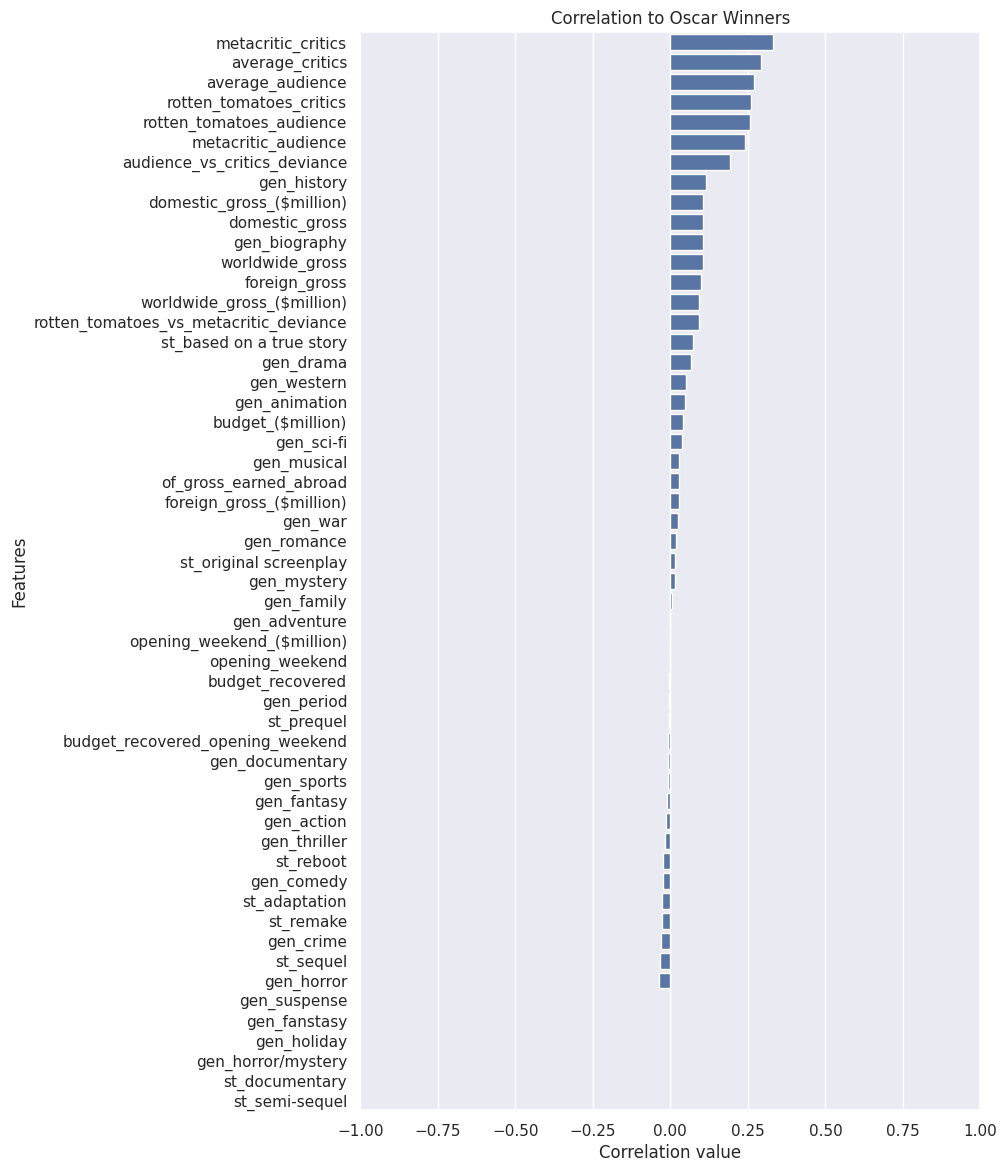

In [25]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)
plt.show()

### 3.2.2 Υπολογισμός Variance Inflation Factor
Υπολογίζουμε το Variance Inflation Factor των χαρακτηριστικών για να διαπιστώσουμε αν υπάρχει φαινόμενο multicollinearity. Σύμφωνα με το αποτέλεσμα υπάρχει τεράστιο φαινόμενο multicollinearity καθώς κάποιες τιμές είναι πολύ μεγάλες.


In [26]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/mike/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/mike/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
46,foreign_gross_($million),inf
50,of_gross_earned_abroad,inf
45,domestic_gross_($million),3195436.80
44,domestic_gross,3194174.49
42,opening_weekend,523193.41
43,opening_weekend_($million),523183.52
38,metacritic_audience,13537.84
34,rotten_tomatoes_critics,13354.20
37,rotten_tomatoes_audience,12599.41
...,...,...


### 3.2.3 Πίνακας συσχέτισης
Υπολογίζουμε τον πίνακα συσχέτισης μεταξύ όλων των χαρακτηριστικών.

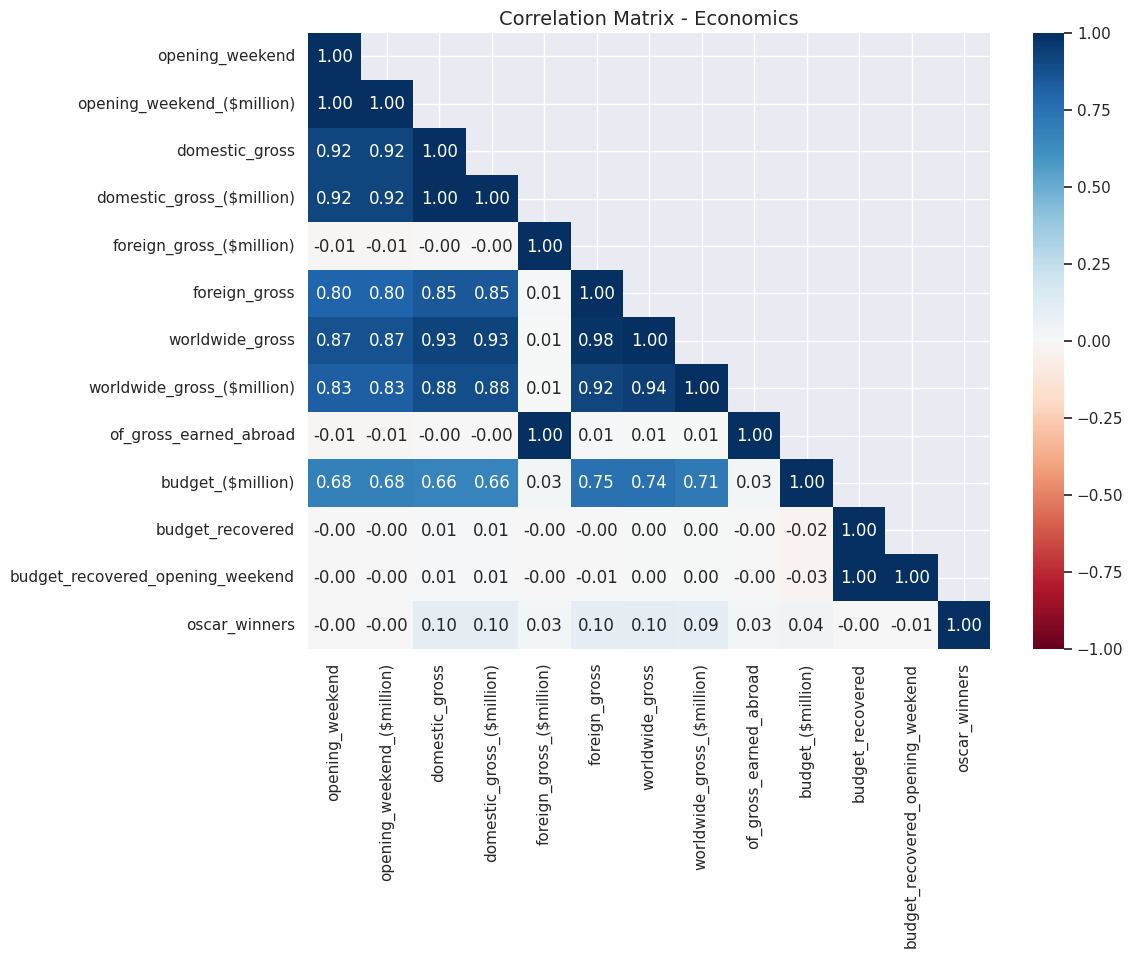

In [27]:
# Economics
corr_mat = df_cl_corr[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(11, 8))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Economics', fontsize=14)
plt.show()

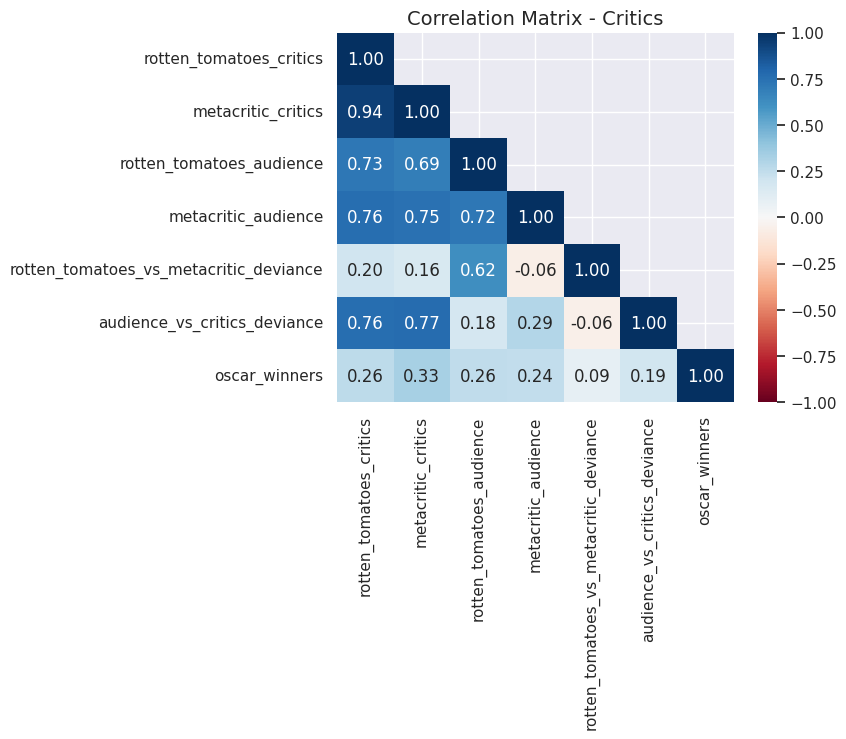

In [28]:
# Economics
corr_mat = df_cl_corr[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance',
       'audience_vs_critics_deviance','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
# plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Critics', fontsize=14)
plt.show()

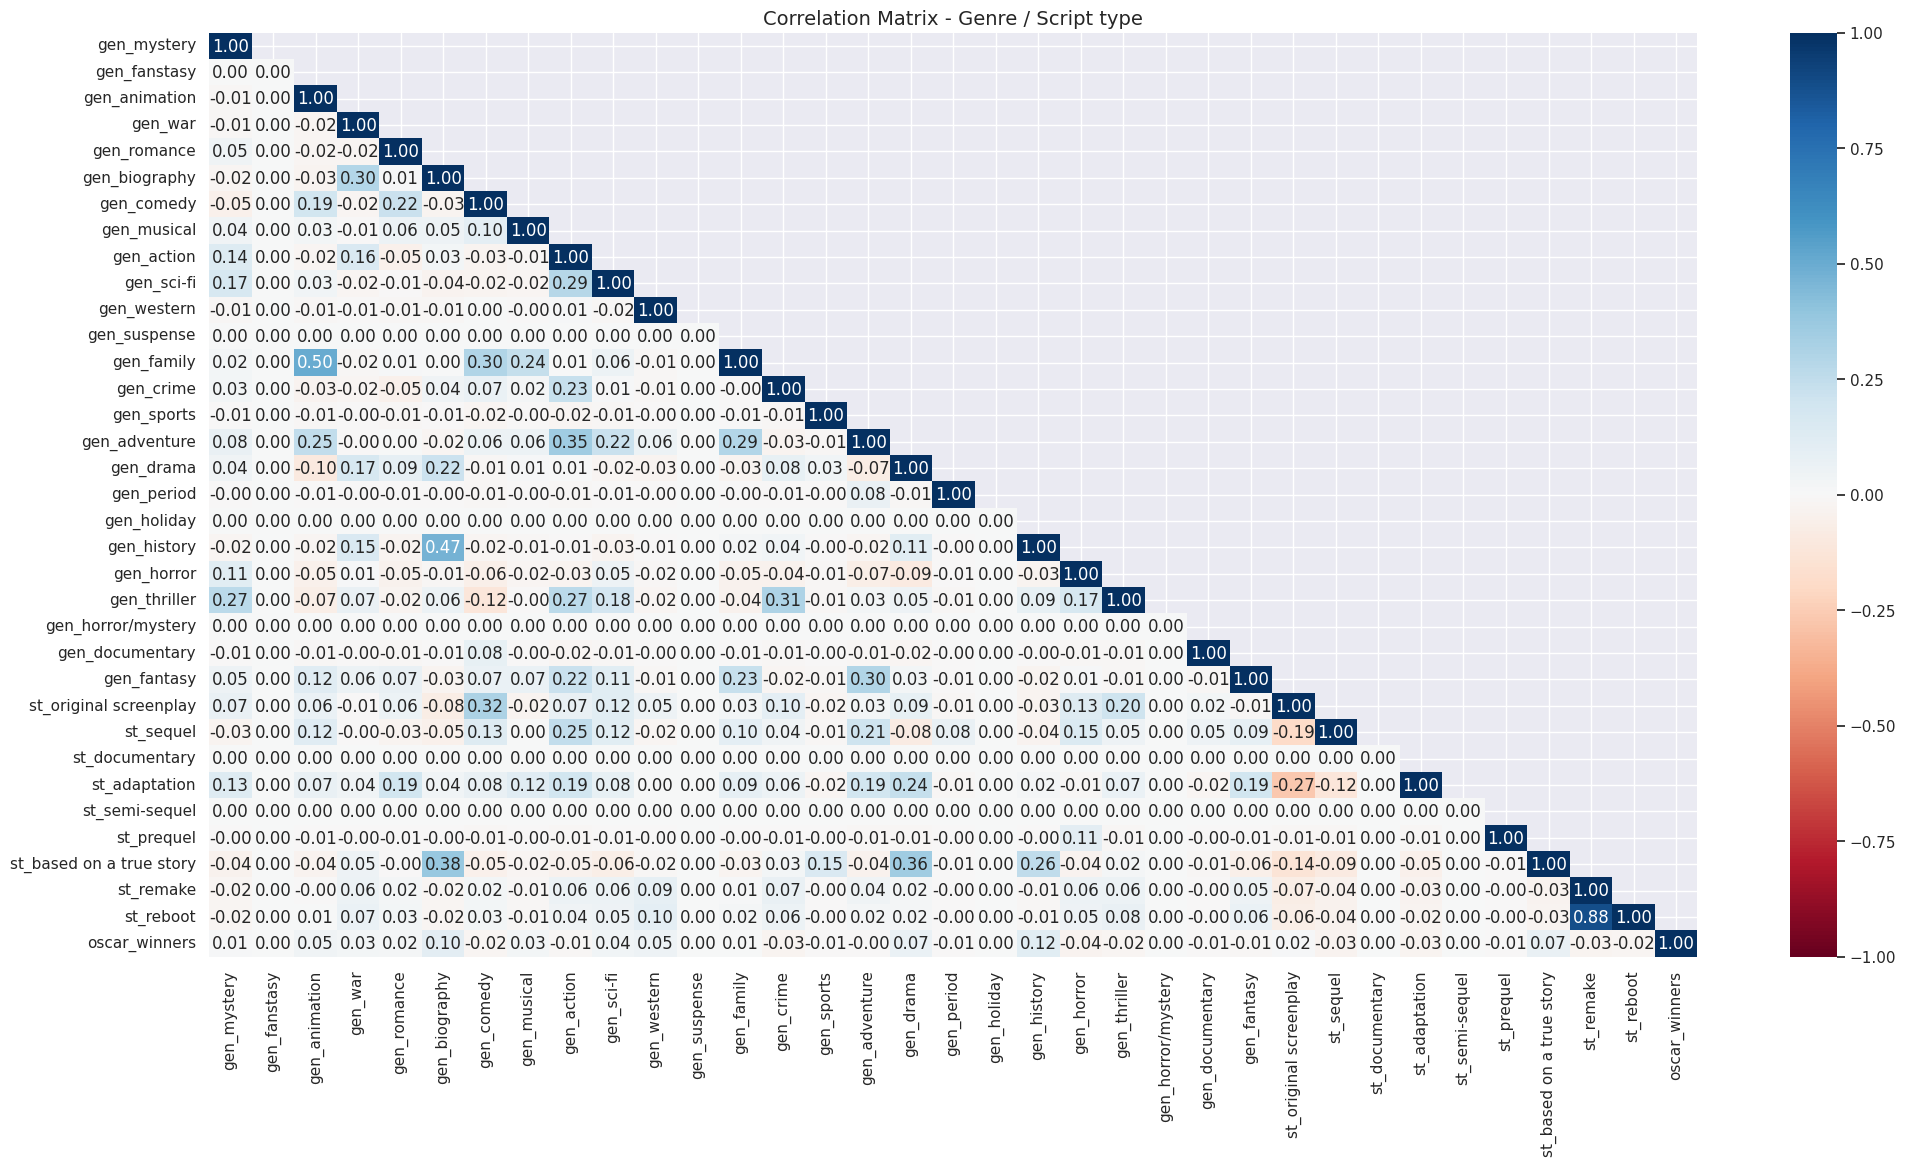

In [29]:
# Economics
corr_mat = df_cl_corr[['gen_mystery', 'gen_fanstasy', 'gen_animation', 'gen_war',
       'gen_romance', 'gen_biography', 'gen_comedy', 'gen_musical',
       'gen_action', 'gen_sci-fi', 'gen_western', 'gen_suspense', 'gen_family',
       'gen_crime', 'gen_sports', 'gen_adventure', 'gen_drama', 'gen_period',
       'gen_holiday', 'gen_history', 'gen_horror', 'gen_thriller',
       'gen_horror/mystery', 'gen_documentary', 'gen_fantasy',
       'st_original screenplay', 'st_sequel', 'st_documentary',
       'st_adaptation', 'st_semi-sequel', 'st_prequel',
       'st_based on a true story', 'st_remake', 'st_reboot','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(24, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Genre / Script type', fontsize=14)
plt.show()

In [30]:
# Plot correlation matrix
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)

# mask = np.zeros_like(corr_mat)
# mask[np.triu_indices_from(mask, k=1)] = True

# sns.set_theme()
# plt.figure(figsize=(30, 12))
# sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Matrix', fontsize=14)
# plt.show()

In [31]:
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)
# corr_mat = corr_mat.iloc[-1]
# corr_mat = corr_mat[corr_mat.values >= 0.05]
# df_cl_sel = df_cl[corr_mat.index]

### 3.2.4 Pairplot μεταξύ κάποιων σημαντικών χαρακτηριστικών.

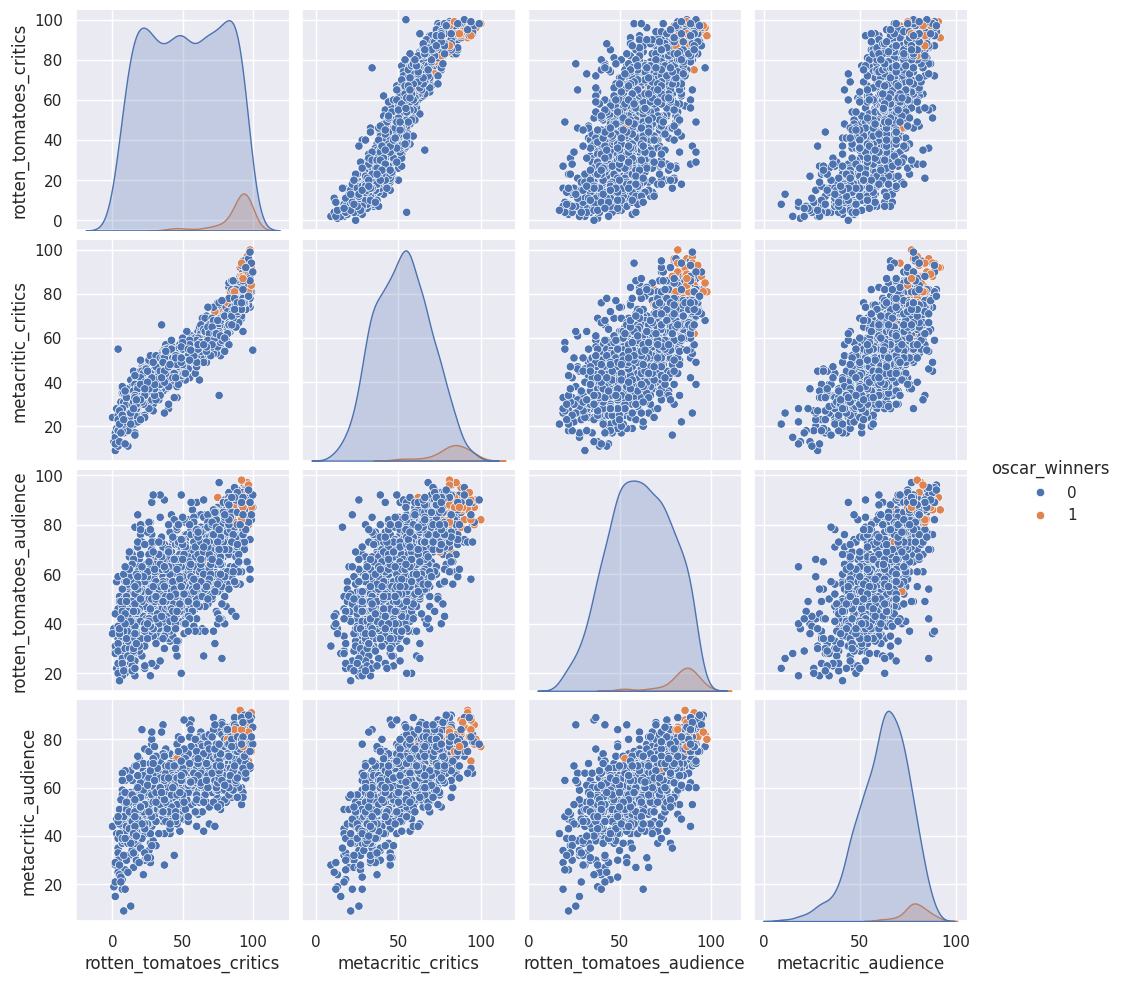

In [32]:
y = df_cl[['oscar_winners']]
# meta = df_cl['film'] 
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')
plt.show()

## 3.3 Principle Components Analysis
Εκτελούμε τον αλγόριθμο PCA για να δούμε αν τα δεδομένα μπορούν να αναπαρασταθούν σε λιγότερες διαστάσεις.

Επιλέγουμε τα πιο σημαντικά χαρακτηριστικά και υπολογίζουμε τις πιο σημαντικές διαστάσεις των Principal Components.

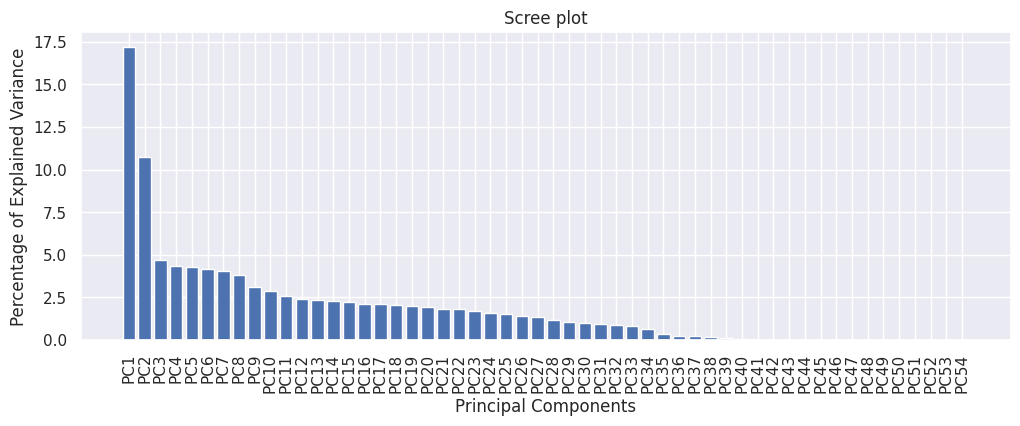

In [33]:
x = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

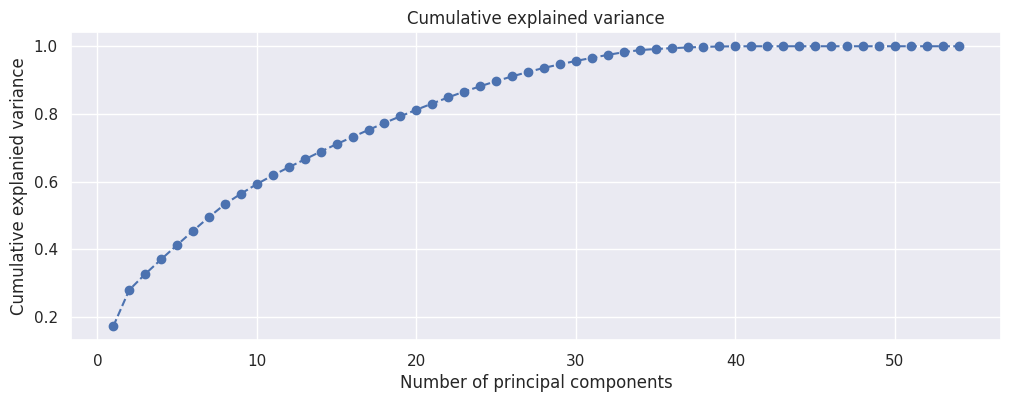

In [34]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

Μπορούμε να διακρίνουμε μία μικρή συσταδοποίηση των oscar winners κάνοντας plot τα πρώτα 2 principal components αλλά λόγω της πυκνότητας δεν έχουμε τα καλά αποτελέσματα.

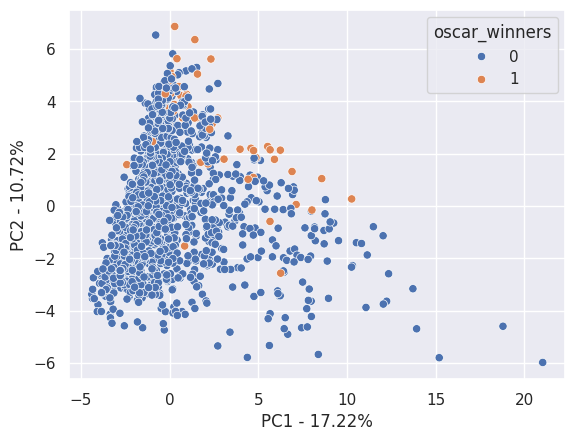

In [35]:
sns.set_theme()
# plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')
plt.show()

Επαναϋπολογίζουμε τα principal components και αυτή τη φορά κρατάμε τα n πρώτα πιο σημαντικά.

In [36]:
# # Calculate PCA
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(x)

# # Concat PCA results to dataframe
# principal_components_df = pd.DataFrame(principal_components)
# principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
# df_cl = pd.concat([df_cl, principal_components_df], axis=1)

# 4. Συσταδοποίηση

## 4.1 KMeans
Χωρήσαμε τα χαρακτηριστικά σε δύο ομάδες. Τα οικονιμά χαρακτηριστικά και οι βαθμολογίες κριτών/κοινού. Στη συνέχεια εκτελέσαμε PCA στις δύο αυτές ομάδες και κάναμε plot τα PC1 και PC2.

### 4.1.1 KMeans - PCA - Economy features

In [37]:
x = df_cl[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']]

# x = df_cl[['opening_weekend_($million)',
#        'domestic_gross_($million)', 'foreign_gross_($million)',
#        'worldwide_gross_($million)',
#        'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
#        'budget_recovered_opening_weekend']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_economic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

Εύρεση αριθμό συστάδων με την μέθοδο elbow

In [38]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

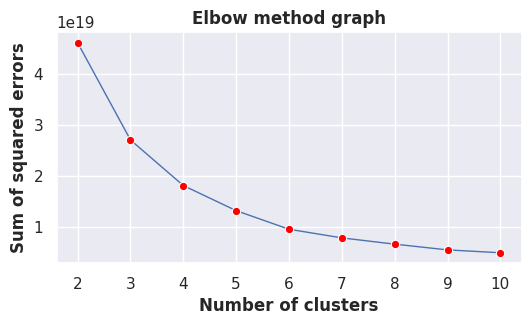

In [39]:
x = df_cl[['PC1_economic', 'PC2_economic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

Εκτελούμε την μεθοδο KMeans συσταδοποίηση με τον αριθμό των συστάδων που βρήκαμε παραπάνω.

In [40]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, n_init='auto')
kmeans_pca.fit(df_cl[['PC1_economic', 'PC2_economic']])

#Append clusters to dataframe
df_cl['kmeans_pca_economic'] = kmeans_pca.labels_

In [41]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_economic']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 236, 0: 1088, 1: 78} | oscars: {2: 18, 0: 32, 1: 6}


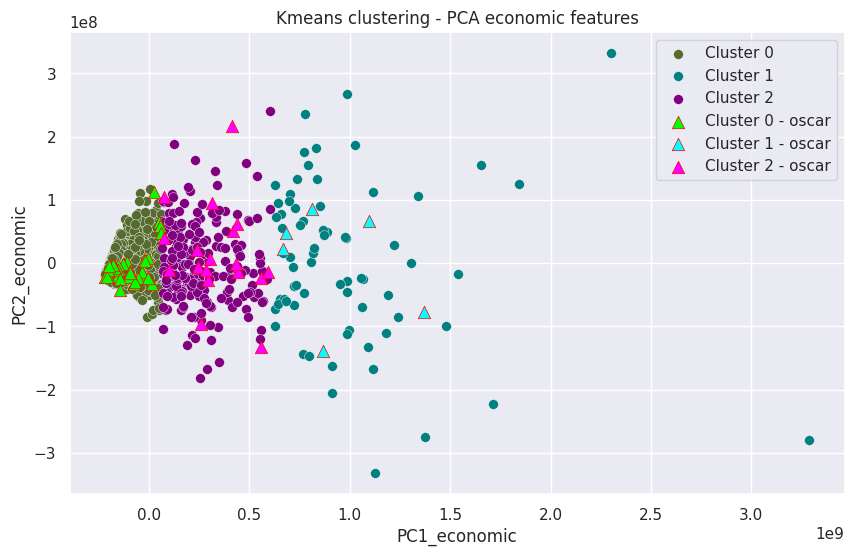

In [42]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_economic', xfeature='PC1_economic', yfeature='PC2_economic', title='Kmeans clustering - PCA economic features')

### 4.1.2 KMeans - PCA Critics

In [43]:
x = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance', 'average_audience',
       'audience_vs_critics_deviance']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_critic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

In [44]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

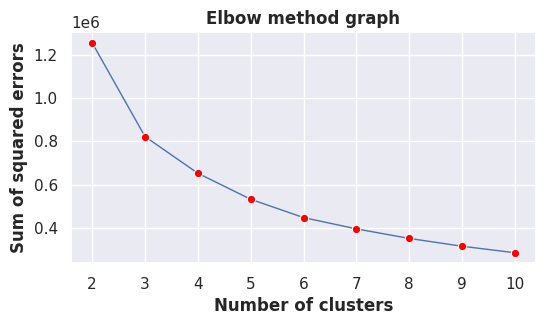

In [45]:
x = df_cl[['PC1_critic', 'PC2_critic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

In [46]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans_pca.fit(df_cl[['PC1_critic', 'PC2_critic']])

#Append clusters to dataframe
df_cl['kmeans_pca_critics'] = kmeans_pca.labels_

In [47]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_critics']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 521, 0: 407, 1: 474} | oscars: {2: 5, 0: 51, 1: 0}


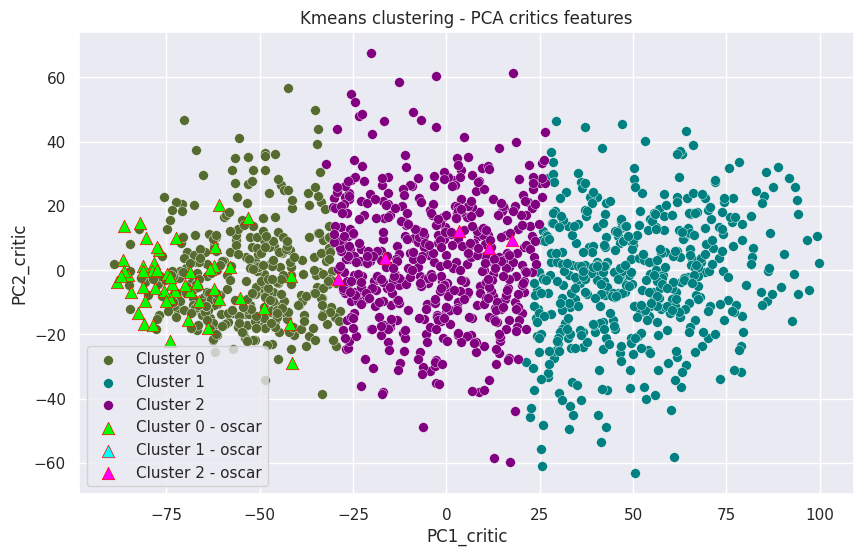

In [48]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_critics', xfeature='PC1_critic', yfeature='PC2_critic', title='Kmeans clustering - PCA critics features')

### Συμπεράσματα kmeans - στατιστικά

#### Συστάδα 0 

Βαθμολογίες κριτικών / κοινού

In [49]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T


,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,407.0,86.282555,7.401322,66.00000,81.0,87.0,92.0,100.0
metacritic_critics,407.0,74.323169,9.139530,54.00000,67.0,73.0,81.0,100.0
average_critics,407.0,80.465290,7.818347,55.37289,75.0,80.0,86.0,99.0
rotten_tomatoes_audience,407.0,80.093366,9.589923,43.00000,74.0,82.0,87.0,98.0
metacritic_audience,407.0,75.248157,7.022121,53.00000,71.0,76.0,80.0,92.0
rotten_tomatoes_vs_metacritic_deviance,407.0,5.213759,9.310517,-19.00000,0.0,5.0,10.0,84.0
average_audience,407.0,77.687961,8.231244,7.00000,73.0,79.0,84.0,93.0
audience_vs_critics_deviance,407.0,2.644737,9.087154,-18.00000,-4.0,2.0,8.0,33.0
oscar_winners,407.0,0.125307,0.331474,0.00000,0.0,0.0,0.0,1.0


Οικονομικά στοιχεία

In [50]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['opening_weekend_($million)',  
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),407.0,28.659337,40.428341,0.00,1.50000,12.7600,39.0650,247.97
domestic_gross_($million),407.0,104.860246,125.796208,0.00,17.26000,59.1000,145.0150,936.66
foreign_gross_($million),407.0,1856.592091,17699.217751,0.00,13.61500,51.3700,208.1700,296402.00
worldwide_gross_($million),407.0,238.621968,324.445090,0.00,31.26000,113.0000,325.6400,2781.50
of_gross_earned_abroad,407.0,18.565921,176.992178,0.00,0.13615,0.5137,2.0817,2964.02
budget_($million),407.0,61.923497,64.107709,0.12,15.00000,33.0000,95.0000,260.00
budget_recovered,407.0,3637.897491,63875.439109,5.00,194.79000,334.2300,559.1300,1289066.67
budget_recovered_opening_weekend,407.0,372.872877,6474.868757,0.16,10.09500,30.8100,59.7750,130666.67


Είδη ταινίας

In [195]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/1104439937.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_drama             106.0
gen_comedy             66.0
gen_action             57.0
gen_adventure          56.0
gen_thriller           50.0
gen_sci-fi             33.0
gen_animation          25.0
gen_crime              24.0
gen_romance            21.0
gen_fantasy            19.0
gen_biography          19.0
gen_horror             15.0
                      ...  
gen_history            11.0
gen_mystery             9.0
gen_musical             4.0
gen_war                 4.0
gen_sports              2.0
gen_western             2.0
gen_fanstasy            NaN
gen_holiday             NaN
gen_documentary         NaN
gen_period              NaN
gen_suspense            NaN
gen_horror/mystery      NaN
Name: 1, Length: 25, dtype: float64

In [54]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/1101740064.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      104.0
st_adaptation                85.0
st_based on a true story     58.0
st_sequel                    36.0
st_remake                     5.0
st_reboot                     4.0
st_documentary                NaN
st_semi-sequel                NaN
st_prequel                    NaN
Name: 1, dtype: float64

#### Συστάδα 1

Βαθμολογίες κριτικών / κοινού

In [196]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,474.0,21.620253,9.996156,0.0,14.0,21.0,29.00,46.0
metacritic_critics,474.0,35.073840,8.118105,9.0,30.0,36.0,41.00,55.0
average_critics,474.0,28.564346,8.376359,6.0,23.0,29.0,35.00,47.0
rotten_tomatoes_audience,474.0,47.725738,13.324566,17.0,39.0,48.0,56.00,90.0
metacritic_audience,474.0,50.421941,11.714324,9.0,44.0,51.0,58.00,84.0
rotten_tomatoes_vs_metacritic_deviance,474.0,-2.696203,13.958581,-44.0,-12.0,-4.0,4.75,45.0
average_audience,474.0,49.305907,10.442447,15.5,43.0,50.0,56.00,78.0
audience_vs_critics_deviance,474.0,-20.970464,10.056246,-48.0,-28.0,-22.0,-15.00,12.0
oscar_winners,474.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


Οικονομικά στοιχεία

In [51]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T


,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),474.0,18.805127,19.103836,0.00,8.01250,13.8750,22.527500,166.0100
domestic_gross_($million),474.0,52.082173,51.096986,0.54,21.30000,37.4700,64.202500,402.1000
foreign_gross_($million),474.0,72.121329,107.860609,0.00,12.32500,36.7600,84.977500,845.9700
worldwide_gross_($million),474.0,122.329243,144.090808,1.00,39.57250,76.2550,150.920000,1123.7900
of_gross_earned_abroad,474.0,0.721213,1.078606,0.00,0.12325,0.3676,0.849775,8.4597
budget_($million),474.0,51.252266,46.395697,0.10,20.00000,35.0000,69.000000,250.0000
budget_recovered,474.0,443.803481,1876.117263,7.75,127.00000,221.4050,344.437500,38164.4100
budget_recovered_opening_weekend,474.0,96.477068,488.915492,0.09,21.22750,35.1250,65.020000,9808.4600


Είδη ταινίας

In [198]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/3334173668.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            98.0
gen_action            77.0
gen_thriller          50.0
gen_drama             43.0
gen_adventure         43.0
gen_horror            40.0
gen_romance           27.0
gen_sci-fi            22.0
gen_fantasy           22.0
gen_crime             16.0
gen_animation         11.0
gen_family             9.0
                      ... 
gen_war                3.0
gen_western            2.0
gen_history            1.0
gen_musical            1.0
gen_biography          1.0
gen_period             1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_documentary        NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

In [55]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/2733431026.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      113.0
st_adaptation                76.0
st_sequel                    57.0
st_remake                     7.0
st_based on a true story      6.0
st_reboot                     4.0
st_documentary                NaN
st_semi-sequel                NaN
st_prequel                    NaN
Name: 1, dtype: float64

#### Συστάδα 2

Βαθμολογίες κριτικών / κοινού

In [199]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,521.0,56.285182,11.475284,26.0,47.0,56.0,66.0,83.0
metacritic_critics,521.0,54.583607,6.417541,33.0,50.0,55.0,59.0,76.0
average_critics,521.0,55.666499,8.259446,37.0,49.0,55.0,62.0,76.0
rotten_tomatoes_audience,521.0,61.188295,11.942036,20.0,54.0,62.0,70.0,92.0
metacritic_audience,521.0,64.577061,7.801889,42.0,60.0,65.0,70.0,89.0
rotten_tomatoes_vs_metacritic_deviance,521.0,-3.507385,11.989239,-60.0,-10.0,-3.0,3.0,34.0
average_audience,521.0,63.113808,8.183310,38.0,58.0,63.0,69.0,83.0
audience_vs_critics_deviance,521.0,-7.584983,11.212743,-42.0,-15.0,-8.0,-1.0,30.0
oscar_winners,521.0,0.009597,0.097586,0.0,0.0,0.0,0.0,1.0


Οικονομικά στοιχεία

In [56]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),521.0,22.934587,23.379319,0.00,8.300,16.070,29.8000,151.12
domestic_gross_($million),521.0,69.989021,68.161567,0.97,24.340,48.090,93.4400,367.23
foreign_gross_($million),521.0,1286.798733,21820.226936,0.00,11.200,46.300,119.1400,489121.00
worldwide_gross_($million),521.0,167.858804,201.338768,1.00,40.540,94.880,211.3400,1235.76
of_gross_earned_abroad,521.0,12.867987,218.202269,0.00,0.112,0.463,1.1914,4891.21
budget_($million),521.0,57.181849,55.232953,0.20,20.000,37.000,75.0000,300.00
budget_recovered,521.0,411.554009,753.449436,8.19,149.780,254.820,416.2600,12074.08
budget_recovered_opening_weekend,521.0,69.698304,140.369126,0.05,22.020,39.520,62.5000,1802.50


Είδη ταινίας

In [201]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/2827174932.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            99.0
gen_drama             84.0
gen_action            74.0
gen_thriller          65.0
gen_adventure         55.0
gen_sci-fi            31.0
gen_horror            29.0
gen_crime             29.0
gen_fantasy           25.0
gen_animation         25.0
gen_romance           24.0
gen_family            22.0
                      ... 
gen_biography          7.0
gen_history            4.0
gen_musical            4.0
gen_war                3.0
gen_documentary        2.0
gen_western            1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_period             NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

In [53]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/3227833518.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      114.0
st_adaptation               109.0
st_sequel                    55.0
st_based on a true story     19.0
st_remake                    11.0
st_reboot                    10.0
st_prequel                    1.0
st_documentary                NaN
st_semi-sequel                NaN
Name: 1, dtype: float64

## 4.3 Agglomerative Clustering
Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

Scatterplot για το Agglomerative Clustering.

### My approach

In [202]:
df_agg = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)

In [203]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{1: 146, 0: 1256}
{1: 15, 0: 41}


In [204]:
df_agg = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]

In [205]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{0: 839, 1: 563}
{0: 3, 1: 53}


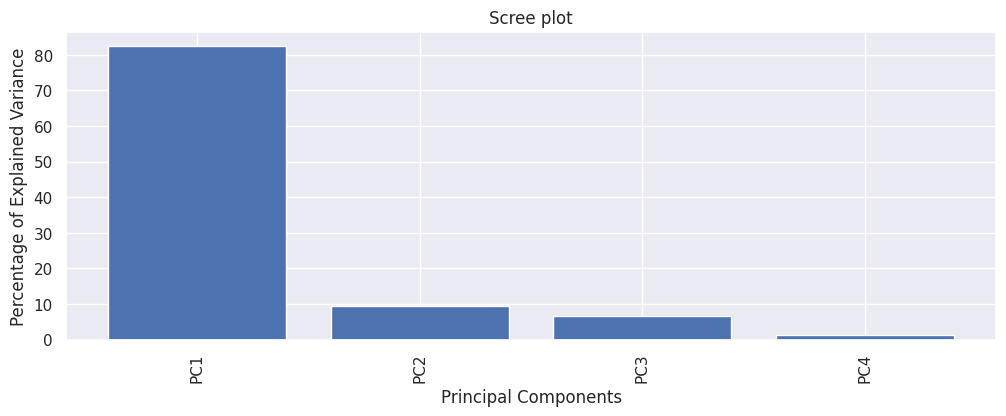

In [206]:
x = df_agg
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_agg_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

In [207]:
# Calculate agglomerative clustering
final_agg_df = final_agg_df.drop(['PC3', 'PC4'], axis=1)
x = final_agg_df.drop(['oscar_winners'], axis=1)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(x)

agg_dict = dict(Counter(agg.labels_))
df_cl['agglomerative'] = agg.labels_
# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{0: 1053, 1: 349}
{0: 5, 1: 51}


In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=final_agg_df['PC1'], y=final_agg_df['PC2'], hue=df_cl['agglomerative'], palette='viridis')

oscar_winners_pca = final_agg_df[final_agg_df['oscar_winners'] == 1]
plt.scatter(oscar_winners_pca['PC1'], oscar_winners_pca['PC2'], color='red', marker='*', s=25 , label='Oscar Winners')

plt.title('Agglomerative Clustering with PCA (Oscar Winners Highlighted)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [ ]:
# cluster_scatter_plot_2D(df_cl, clusters_column='agglomerative', xfeature='PC1_critic', yfeature='PC2_critic', title='Agglomerative clustering')

## 4.4 Αξιολόγηση αλγόριθμων συσταδοποίησης



- KMeans Clustering

In [ ]:
# Define datasets for each KMeans clustering
X_kmeans_pca = df_kmeans_pca
X_kmeans_critics = df_kmeans
X_kmeans_audience = df_audience_features

# Function to evaluate clustering
def evaluate_clustering(X, labels, clustering_name):
    silhouette = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)

    print(f"{clustering_name} Evaluation")
    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print(f"Davies-Bouldin Index: {davies_bouldin}\n")

# Evaluating KMeans clusterings
evaluate_clustering(X_kmeans_pca, df_cl['kmeans_pca'], "KMeans PCA")
evaluate_clustering(X_kmeans_critics, df_cl['kmeans'], "KMeans Critics")
evaluate_clustering(X_kmeans_audience, df_cl['kmeans_audience'], "KMeans Audience")

KMeans PCA Evaluation
Silhouette Score: 0.4389228689555876
Calinski-Harabasz Index: 1389.6714521121023
Davies-Bouldin Index: 0.7646472344262609

KMeans Critics Evaluation
Silhouette Score: 0.5002010782876959
Calinski-Harabasz Index: 4813.418625852946
Davies-Bouldin Index: 0.6038780529166075

KMeans Audience Evaluation
Silhouette Score: 0.37752323975040425
Calinski-Harabasz Index: 1779.1423064854275
Davies-Bouldin Index: 0.8831512153112048



- DBSCAN Clustering


In [ ]:
mask = df_cl['dbscan'] != -1
silhouette_dbscan = silhouette_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])
calinski_harabasz_dbscan = calinski_harabasz_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])
davies_bouldin_dbscan = davies_bouldin_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])

print("\nDBSCAN Clustering Evaluation")
print(f"Silhouette Score: {silhouette_dbscan}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_dbscan}")
print(f"Davies-Bouldin Index: {davies_bouldin_dbscan}")


DBSCAN Clustering Evaluation
Silhouette Score: 0.3382894582384262
Calinski-Harabasz Index: 48.329249445568536
Davies-Bouldin Index: 0.5180020048441863


- Agglomerative Clustering


In [ ]:
silhouette_agglo = silhouette_score(X_aglm, df_cl['agg'])
calinski_harabasz_agglo = calinski_harabasz_score(X_aglm, df_cl['agg'])
davies_bouldin_agglo = davies_bouldin_score(X_aglm, df_cl['agg'])

print("Agglomerative Clustering Evaluation")
print(f"Silhouette Score: {silhouette_agglo}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_agglo}")
print(f"Davies-Bouldin Index: {davies_bouldin_agglo}")

Agglomerative Clustering Evaluation
Silhouette Score: 0.47726851035018075
Calinski-Harabasz Index: 2068.533510134978
Davies-Bouldin Index: 0.7119733883363499


--- 

Aξιολογούμε την απόδοση τριών διαφορετικών αλγορίθμων ομαδοποίησης: KMeans (εφαρμόζεται σε χαρακτηριστικά PCA, βαθμολογίες κριτικών και βαθμολογίες κοινού), DBSCAN και Agglomerative Clustering. Η αξιολόγηση βασίζεται σε τρεις βασικές μετρήσεις: Δείκτης Silhouette, Δείκτης Calinski-Harabasz και Δείκτης Davies-Bouldin. Αυτές οι μετρήσεις παρέχουν πληροφορίες για την πυκνότητα, τον διαχωρισμό και τη διακριτότητα των συστάδων που σχηματίζονται από κάθε αλγόριθμο.

Πιο συγκεκριμένα: 

- Βαθμολογία Silhouette: Μετρά πόσο παρόμοιο είναι ένα αντικείμενο με το δικό του σύμπλεγμα σε σύγκριση με άλλα συμπλέγματα. Μια υψηλότερη βαθμολογία υποδηλώνει καλύτερη συνοχή και διαχωρισμό συστάδων.
- Δείκτης Calinski-Harabasz: Αξιολογεί συστάδες με βάση τη μέση διακύμανση μεταξύ των κλάδων διαιρούμενων με τη διακύμανση εντός της κάθε "ομάδας". Οι υψηλότερες βαθμολογίες υποδηλώνουν καλύτερα καθορισμένες ομάδες.
- Δείκτης Davies-Bouldin: Μετρά τη μέση ομοιότητα μεταξύ κάθε συστάδας και της πιο παρόμοιας συστάδας. Οι χαμηλότερες τιμές υποδηλώνουν καλύτερη ομαδοποίηση.

Προς διευκολία ερμήνευσης των αποτελεσμάτων, κάνουμε το παρακάτω bar graph:

In [ ]:
# Data preparation
methods = ['KMeans (PCA)', 'KMeans (Critics)', 'KMeans (Audience)', 'DBSCAN', 'Agglomerative']
silhouette_scores = [0.4396, 0.5012, 0.3768, 0.3383, 0.4857]
calinski_scores = [1410.003, 4816.516, 1779.594, 48.326, 2182.376]
davies_scores = [0.7714, 0.6035, 0.8814, 0.5180, 0.7225]
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(15, 5))

# Silhouette Score plot
plt.subplot(1, 3, 1)
for i, method in enumerate(methods):
    plt.bar(method, silhouette_scores[i], color=colors[i])
plt.title('Silhouette Scores (Higher is better)')
plt.xticks(rotation=45)

# Calinski-Harabasz plot
plt.subplot(1, 3, 2)
for i, method in enumerate(methods):
    plt.bar(method, calinski_scores[i], color=colors[i])
plt.title('Calinski-Harabasz Index (Higher is better)')
plt.xticks(rotation=45)

# Davies-Bouldin plot
plt.subplot(1, 3, 3)
for i, method in enumerate(methods):
    plt.bar(method, davies_scores[i], color=colors[i])
plt.title('Davies-Bouldin Index (Lower is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Ομαδοποίηση KMeans:

- Οι βαθμολογίες KMeans για τους Critics ξεπέρασαν τις άλλες μεθόδους KMeans με τον υψηλότερο δείκτη Calinski-Harabasz, υποδεικνύοντας εξαιρετικά πυκνά και καλά διαχωρισμένα συμπλέγματα. Πέτυχε επίσης τον χαμηλότερο δείκτη Davies-Bouldin, υποδηλώνοντας ελάχιστη επικάλυψη (overlap) μεταξύ των συστάδων.

- Το KMeans στα χαρακτηριστικά PCA παρουσίασε μέτρια απόδοση, υποδεικνύοντας εύλογο σχηματισμό συμπλέγματος, αλλά με περιθώρια βελτίωσης στον διαχωρισμό και τη συνοχή.

- Οι βαθμολογίες KMeans στο Audience παρουσίασαν χαμηλότερη απόδοση, ιδιαίτερα όσον αφορά τη βαθμολογία Silhouette, υποδηλώνοντας λιγότερο ευδιάκριτη ομαδοποίηση.

Ομαδοποίηση DBSCAN:

- Το DBSCAN είχε τον χαμηλότερο δείκτη Calinski-Harabasz, υποδεικνύοντας λιγότερο πυκνά και κακώς διαχωρισμένα συμπλέγματα, κάτι που είναι κοινό χαρακτηριστικό του DBSCAN όταν ασχολείται με δεδομένα υψηλών διαστάσεων ή λιγότερο ευδιάκριτα. Ωστόσο, πέτυχε έναν σχετικά χαμηλό δείκτη Davies-Bouldin, υποδεικνύοντας εύλογο διαχωρισμό μεταξύ των συστάδων.

Ομαδοποίηση Agglomerative:

- Αυτή η μέθοδος έδειξε ισχυρή ισορροπία σε όλες τις μετρήσεις, με την υψηλότερη βαθμολογία Silhouette μεταξύ όλων των μεθόδων, υποδηλώνοντας καλή συνοχή και διαχωρισμό συμπλέγματος.

---

Συμπεράσματα:

- Το KMeans με βαθμολογίες Critics φαίνεται να είναι η πιο αποτελεσματική μέθοδος για αυτό το συγκεκριμένο σύνολο δεδομένων, ιδιαίτερα όταν η πυκνότητα και ο διαχωρισμός συμπλέγματος είναι πρωταρχικής σημασίας.

- Η Agglomerative ομαδοποίηση είναι ένας ισχυρός υποψήφιος, ειδικά για σενάρια όπου η συνοχή των συστάδων είναι κρίσιμη.

- Το DBSCAN μπορεί να απαιτεί συντονισμό παραμέτρων ή μπορεί να μην είναι το ίδιο κατάλληλο για αυτό το σύνολο δεδομένων, δεδομένης της χαμηλότερης απόδοσής του σε βασικές μετρήσεις.

# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

In [ ]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [ ]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')

## 5.1 Νευρωνικό δίκτυο

In [ ]:
# remove unecessesary features from dataset
# df_nn = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
#                     'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
#                     'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
#                     'oscar_detail','PC1','PC2','kmeans_pca','kmeans','dbscan','agg'], axis=1)

# df_nn = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
#                     'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
#                     'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
#                     'oscar_detail'], axis=1)

# # Separate testing split from dataset
# df_nn_train, df_nn_test = train_test_split(df_nn, test_size=0.2, stratify=df_nn['oscar_winners'])

# # Separate classes
# df_nn_majority = df_nn_train[(df_nn_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
# df_nn_minority = df_nn_train[(df_nn_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

### 5.1.1 Upsampling

In [ ]:
# df_nn_minority_upsampled = resample(df_nn_minority, replace=True, n_samples= len(df_nn_majority), random_state=42)

# df_nn_minority_upsampled = df_nn_minority_upsampled.reset_index().drop('index', axis=1)

# df_nn_upsampled = pd.concat([df_nn_minority_upsampled, df_nn_majority]).sort_index(kind='merge')
# df_nn_upsampled = df_nn_upsampled.reset_index().drop('index', axis=1)

#### Εκπαίδευση μοντέλου

In [ ]:
# # Prepare dataset for training k-fold splits
# X = df_nn_upsampled.drop(['oscar_winners'], axis=1)
# y = df_nn_upsampled[['oscar_winners']]

# # Create k-fold splits and stratify classes
# kf = StratifiedKFold(n_splits=5, shuffle=False)

# reports_ups_nn = []
# for i, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

#     train, validate = df_nn_upsampled.iloc[train_idx], df_nn_upsampled.iloc[valid_idx]
#     # separate labels and convert to tensor
#     X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, cnbype=torch.float32) 
#     X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, cnbype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

#     nn_input_features = X_train.shape[1]

#     model = OscarClassificationNeuralNetwork(input_features=nn_input_features, 
#                                                 hidden_layer_input_features = nn_input_features,
#                                                 hidden_layer_output_features = nn_input_features,
#                                                 device='cpu',                                               
#                                                 learning_rate=0.01)
    
#     train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=False)
    
#     # Test on test split
#     X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
#     y_pred, acc = model.test(accuracy_fn, X_test, y_test)

#     print(f"Fold {i} test accuracy: {acc:.4f}")



#     report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
#     reports_ups_nn.append({'label' : 'Upsampling',
#                             'report': report,
#                             'true' : y_test.to('cpu').numpy(),
#                             'preds' : y_pred.to('cpu').numpy(),
#                             'dict' : model.state_dict()})

# best_performing_ups_nn_model = max(reports_ups_nn, key=lambda a:a['report']['1.0']['f1-score'])
# best_performing_ups_nn_model['true'] = best_performing_ups_nn_model['true'].flatten()
# best_performing_ups_nn_model['preds'] = best_performing_ups_nn_model['preds'].flatten()

### 5.1.2 Downsampling

In [ ]:
# df_nn_majority_downsampled = resample(df_nn_majority, replace=True, n_samples= len(df_nn_minority), random_state=42)

# df_nn_majority_downsampled = df_nn_majority_downsampled.reset_index().drop('index', axis=1)

# df_nn_downsampled = pd.concat([df_nn_majority_downsampled, df_nn_minority]).sort_index(kind='merge')
# df_nn_downsampled = df_nn_downsampled.reset_index().drop('index', axis=1)

#### Εκπαίδευση μοντέλου

In [ ]:
# # Prepare dataset for training k-fold splits
# X = df_nn_downsampled.drop(['oscar_winners'], axis=1)
# y = df_nn_downsampled[['oscar_winners']]

# # Create k-fold splits and stratify classes
# kf = StratifiedKFold(n_splits=5, shuffle=False)

# reports_dwn_nn = []
# for i, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

#     train, validate = df_nn_downsampled.iloc[train_idx], df_nn_downsampled.iloc[valid_idx]
#     # separate labels and convert to tensor
#     X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
#     X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

#     model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
#                                                 hidden_layer_input_features = X_train.shape[1],
#                                                 hidden_layer_output_features = X_train.shape[1],
#                                                 device='cpu',                                               
#                                                 learning_rate=0.01)
    
#     train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=False)
    
#     # Test on test split
#     X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
#     y_pred, acc = model.test(accuracy_fn, X_test, y_test)

#     print(f"Fold {i} test accuracy: {acc:.4f}")

#     report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
#     reports_dwn_nn.append({ 'label' : 'Downsampling',
#                             'report':report,
#                             'true' : y_test.to('cpu').numpy(),
#                             'preds' : y_pred.to('cpu').numpy(),
#                             'dict' : model.state_dict()})

# best_performing_dwn_nn_model = max(reports_dwn_nn, key=lambda a:a['report']['1.0']['f1-score'])
# best_performing_dwn_nn_model['true'] = best_performing_dwn_nn_model['true'].flatten()
# best_performing_dwn_nn_model['preds'] = best_performing_dwn_nn_model['preds'].flatten()

### 5.1.3 SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
# sm = SMOTE(sampling_strategy='minority', random_state=42)

# df_nn_oversampled_X, df_nn_oversampled_Y = sm.fit_resample(df_nn_train.drop('oscar_winners', axis=1), df_nn_train['oscar_winners'])
# df_nn_oversampled = pd.concat([pd.DataFrame(df_nn_oversampled_X), pd.DataFrame(df_nn_oversampled_Y)], axis=1)

Εκπαίδευση μοντέλου

In [ ]:
# # Prepare dataset for training k-fold splits
# X = df_nn_oversampled.drop(['oscar_winners'], axis=1)
# y = df_nn_oversampled[['oscar_winners']]

# # Create k-fold splits and stratify classes
# kf = StratifiedKFold(n_splits=5, shuffle=False)

# reports_smote_nn = []
# for i, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

#     train, validate = df_nn_oversampled.iloc[train_idx], df_nn_oversampled.iloc[valid_idx]
#     # separate labels and convert to tensor
#     X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
#     X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

#     model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
#                                                 hidden_layer_input_features = X_train.shape[1],
#                                                 hidden_layer_output_features = X_train.shape[1],
#                                                 device='cpu',                                               
#                                                 learning_rate=0.01)
    
#     train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=False)
    
#     # Test on test split
#     X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
#     y_pred, acc = model.test(accuracy_fn, X_test, y_test)

#     print(f"Fold {i} test accuracy: {acc:.4f}")

#     report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
#     reports_smote_nn.append({'label':'SMOTE',
#                             'report':report,
#                             'true' : y_test.to('cpu').numpy(),
#                             'preds' : y_pred.to('cpu').numpy(),
#                             'dict' : model.state_dict()})

# best_performing_smote_nn_model = max(reports_smote_nn, key=lambda a:a['report']['1.0']['f1-score'])
# best_performing_smote_nn_model['true'] = best_performing_smote_nn_model['true'].flatten()
# best_performing_smote_nn_model['preds'] = best_performing_smote_nn_model['preds'].flatten()

### 5.1.4 Default

Εκπαίδευση μοντέλου

In [ ]:
# # Prepare dataset for training k-fold splits
# X = df_nn_train.drop(['oscar_winners'], axis=1)
# y = df_nn_train[['oscar_winners']]

# # Create k-fold splits and stratify classes
# kf = StratifiedKFold(n_splits=5, shuffle=False)

# reports_default_nn = []
# for i, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):

#     train, validate = df_nn_train.iloc[train_idx], df_nn_train.iloc[valid_idx]
#     # separate labels and convert to tensor
#     X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
#     X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

#     model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
#                                                 hidden_layer_input_features = X_train.shape[1],
#                                                 hidden_layer_output_features = X_train.shape[1],
#                                                 device='cpu',                                               
#                                                 learning_rate=0.01)
    
#     train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=False)
    
#     # Test on test split
#     X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
#     y_pred, acc = model.test(accuracy_fn, X_test, y_test)

#     print(f"Fold {i} test accuracy: {acc:.4f}")

#     report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
#     reports_default_nn.append({'label':'Default',
#                             'report':report,
#                             'true' : y_test.to('cpu').numpy(),
#                             'preds' : y_pred.to('cpu').numpy(),
#                             'dict' : model.state_dict()})

# best_performing_default_nn_model = max(reports_default_nn, key=lambda a:a['report']['1.0']['f1-score'])
# best_performing_default_nn_model['true'] = best_performing_default_nn_model['true'].flatten()
# best_performing_default_nn_model['preds'] = best_performing_default_nn_model['preds'].flatten()

### 5.1.5 Plots Neural Network

In [ ]:
# plot_roc_curves(best_performing_ups_nn_model, best_performing_dwn_nn_model, best_performing_smote_nn_model, best_performing_default_nn_model, 'ROC Curves (best from 5-fold) - Neural Network')

In [ ]:
# plot_confusion_matrices((best_performing_ups_nn_model, best_performing_dwn_nn_model, best_performing_smote_nn_model, best_performing_default_nn_model), 'Confusion Matrices (best f1 score from 5-folds) - Neural Network')

In [ ]:
# plot_classification_reports_averages((reports_ups_nn, reports_dwn_nn, reports_smote_nn, reports_default_nn),'Classification Report (5-folds average) - Neural Network')

## 5.2 K-Nearest Neighbors classification model

#### Data preparation

In [ ]:
# remove unecessesary features from dataset
df_knn = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'opening_weekend_($million)', 'domestic_gross_($million)',
       'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

# Separate testing split from dataset
df_knn_train, df_knn_test = train_test_split(df_knn, test_size=0.2, stratify=df_knn['oscar_winners'])

# Separate classes
df_knn_majority = df_knn_train[(df_knn_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
df_knn_minority = df_knn_train[(df_knn_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

#### 5.2.1 Upsampling

In [ ]:
# Upsample the minority class of the dataset
df_knn_minority_upsampled = resample(df_knn_minority, replace=True, n_samples= len(df_knn_majority), random_state=42)

df_knn_minority_upsampled = df_knn_minority_upsampled.reset_index().drop('index', axis=1)

df_knn_upsampled = pd.concat([df_knn_minority_upsampled, df_knn_majority]).sort_index(kind='merge')
df_knn_upsampled = df_knn_upsampled.reset_index().drop('index', axis=1)

In [ ]:
# Find optimal number of neighbours for KNN model using cross validation score
k_values = [i for i in range (2, 15)] # TODO k_values must be <= features? error: Expected n_neighbors <= n_samples,  but n_samples = 18, n_neighbors = 30
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, df_knn_upsampled.drop(['oscar_winners'], axis=1), df_knn_upsampled['oscar_winners'], cv=5)
    scores.append(np.mean(score))
best_index = np.argmax(scores)
best_k = k_values[best_index]

In [ ]:
# Prepare dataset for training k-fold splits
X = df_knn_upsampled.drop(['oscar_winners'], axis=1)
y = df_knn_upsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_ups_knn = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_knn_upsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_knn_test.drop(['oscar_winners'], axis=1).values, df_knn_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_ups_knn.append({'label' : 'Upsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'best_k' : best_k,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_ups_knn_model = max(reports_ups_knn, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.8932
Fold 2 test accuracy: 0.9110
Fold 3 test accuracy: 0.8932
Fold 4 test accuracy: 0.9110
Fold 5 test accuracy: 0.8932


#### 5.2.2 Downsampling

In [ ]:
# Downsample the majority class of the dataset
df_knn_majority_downsampled = resample(df_knn_majority, replace=True, n_samples= len(df_knn_minority), random_state=42)

df_knn_majority_downsampled = df_knn_majority_downsampled.reset_index().drop('index', axis=1)

df_knn_downsampled = pd.concat([df_knn_majority_downsampled, df_knn_minority]).sort_index(kind='merge')
df_knn_downsampled = df_knn_downsampled.reset_index().drop('index', axis=1)

In [ ]:
# Find optimal number of neighbours for KNN model using cross validation score
# k_values = [i for i in range (2,31)]
k_values = [i for i in range (2, 15)] 
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, df_knn_downsampled.drop(['oscar_winners'], axis=1), df_knn_downsampled['oscar_winners'], cv=5)
    scores.append(np.mean(score))
best_index = np.argmax(scores)
best_k = k_values[best_index]

In [ ]:
# Prepare dataset for training k-fold splits
X = df_knn_downsampled.drop(['oscar_winners'], axis=1)
y = df_knn_downsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_dwn_knn = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_knn_downsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    best_k_a = 1 if int(np.round(best_k / 5)) == 0 else int(np.round(best_k / 5))


    model = KNeighborsClassifier(n_neighbors=int(np.round(best_k / 5))) #TODO this is the error 
    # model = KNeighborsClassifier(n_neighbors=best_k_a)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_knn_test.drop(['oscar_winners'], axis=1).values, df_knn_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")
          
    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_dwn_knn.append({'label' : 'Downsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'best_k' : best_k,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_dwn_knn_model = max(reports_dwn_knn, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.8683
Fold 2 test accuracy: 0.7402
Fold 3 test accuracy: 0.7189
Fold 4 test accuracy: 0.8256
Fold 5 test accuracy: 0.6512


#### 5.2.3 SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
# Resample using SMOTE method
sm = SMOTE(sampling_strategy='minority', random_state=42)

df_knn_oversampled_X, df_knn_oversampled_Y = sm.fit_resample(df_knn_train.drop('oscar_winners', axis=1), df_knn_train['oscar_winners'])
df_knn_oversampled = pd.concat([pd.DataFrame(df_knn_oversampled_X), pd.DataFrame(df_knn_oversampled_Y)], axis=1)

In [ ]:
# Find optimal number of neighbours for KNN model using cross validation score
# k_values = [i for i in range (2,31)]
k_values = [i for i in range (2, 15)] 
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, df_knn_oversampled.drop(['oscar_winners'], axis=1), df_knn_oversampled['oscar_winners'], cv=5)
    scores.append(np.mean(score))
best_index = np.argmax(scores)
best_k = k_values[best_index]

In [ ]:
# Prepare dataset for training k-fold splits
X = df_knn_oversampled.drop(['oscar_winners'], axis=1)
y = df_knn_oversampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_smote_knn = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_knn_oversampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, y_train)
    
    # Test on test split
    X_test, y_test = df_knn_test.drop(['oscar_winners'], axis=1).values, df_knn_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")
      
    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_smote_knn.append({'label' : 'SMOTE',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'best_k' : best_k,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_smote_knn_model = max(reports_smote_knn, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.8861
Fold 2 test accuracy: 0.9004
Fold 3 test accuracy: 0.8897
Fold 4 test accuracy: 0.9146
Fold 5 test accuracy: 0.9004


#### 5.2.4 Default

In [ ]:
# Prepare dataset for training k-fold splits
X = df_knn_train.drop(['oscar_winners'], axis=1)
y = df_knn_train[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_default_knn = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_knn_train.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, y_train)
 
    # Test on test split
    X_test, y_test = df_knn_test.drop(['oscar_winners'], axis=1).values, df_knn_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")
      
    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_default_knn.append({'label' : 'Default',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'best_k' : best_k,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_default_knn_model = max(reports_default_knn, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9573
Fold 2 test accuracy: 0.9644
Fold 3 test accuracy: 0.9573
Fold 4 test accuracy: 0.9609
Fold 5 test accuracy: 0.9573


#### 5.2.5 Plot testing metrics

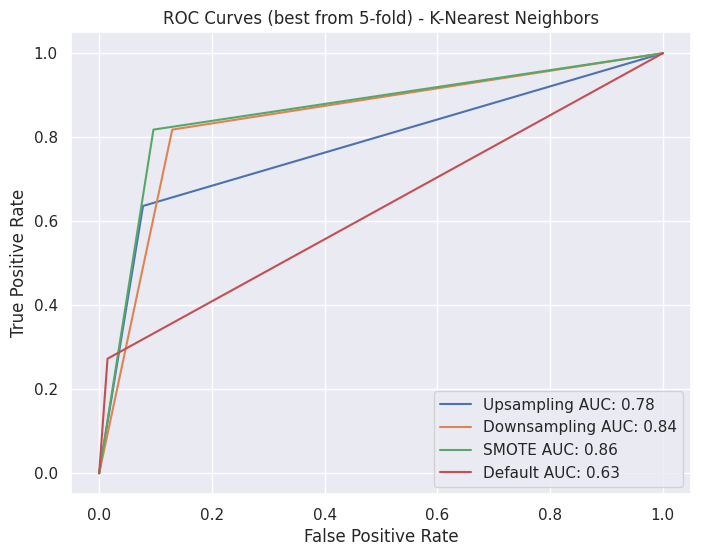

In [ ]:
plot_roc_curves(best_performing_ups_knn_model,
                best_performing_dwn_knn_model,
                best_performing_smote_knn_model,
                best_performing_default_knn_model, 'ROC Curves (best from 5-fold) - K-Nearest Neighbors')

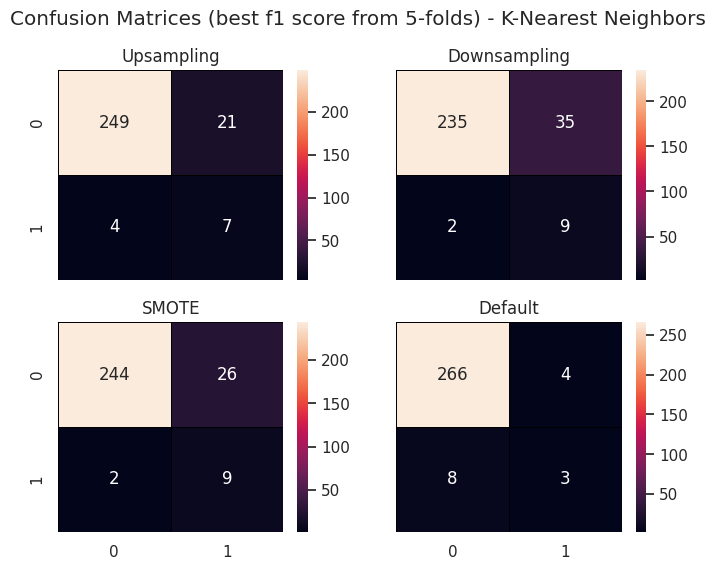

In [ ]:
plot_confusion_matrices((best_performing_ups_knn_model,
                         best_performing_dwn_knn_model,
                         best_performing_smote_knn_model,
                         best_performing_default_knn_model), 'Confusion Matrices (best f1 score from 5-folds) - K-Nearest Neighbors')

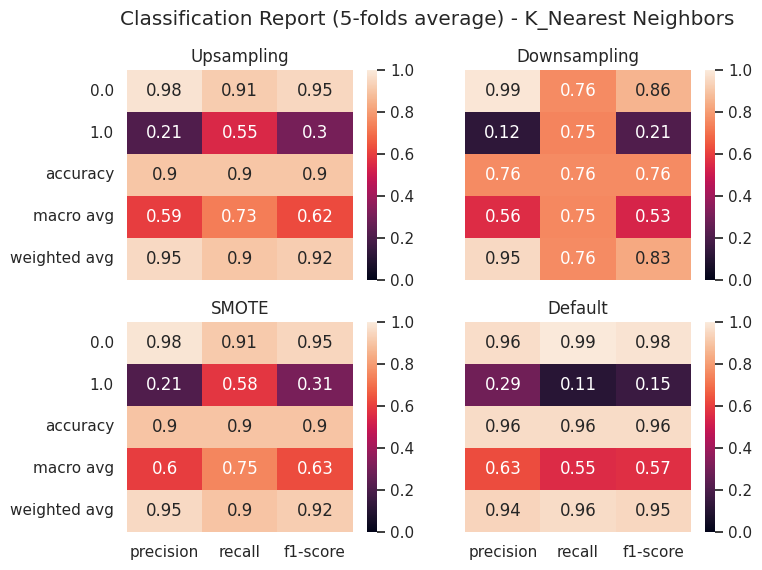

In [ ]:
plot_classification_reports_averages((reports_ups_knn,
                                      reports_dwn_knn,
                                      reports_smote_knn,
                                      reports_default_knn),'Classification Report (5-folds average) - K_Nearest Neighbors')

## 5.3 Decision Tree

#### 5.3.1 Data preparation

In [ ]:
# remove unecessesary features from dataset
df_dt = df_cl[['metacritic_critics', 'opening_weekend_($million)',
               'domestic_gross_($million)', 'foreign_gross_($million)',
               'oscar_winners']]

# Separate testing split from dataset
df_dt_train, df_dt_test = train_test_split(df_dt, test_size=0.2, stratify=df_dt['oscar_winners'])

# Separate classes
df_dt_majority = df_dt_train[(df_dt_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
df_dt_minority = df_dt_train[(df_dt_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

#### 5.3.2 Upsampling

In [ ]:
# Umpsample the minority class
df_dt_minority_upsampled = resample(df_dt_minority, replace=True, n_samples= len(df_dt_majority), random_state=42)

df_dt_minority_upsampled = df_dt_minority_upsampled.reset_index().drop('index', axis=1)

df_dt_upsampled = pd.concat([df_dt_minority_upsampled, df_dt_majority]).sort_index(kind='merge')
df_dt_upsampled = df_dt_upsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_dt_upsampled.drop(['oscar_winners'], axis=1)
y = df_dt_upsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_ups_dt = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_dt_upsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = DecisionTreeClassifier(criterion='gini', splitter='best')
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_dt_test.drop(['oscar_winners'], axis=1).values, df_dt_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_ups_dt.append({'label' : 'Upsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_ups_dt_model = max(reports_ups_dt, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9181
Fold 2 test accuracy: 0.9359
Fold 3 test accuracy: 0.9537
Fold 4 test accuracy: 0.9537
Fold 5 test accuracy: 0.9502


#### 5.3.3 Downsampling

In [ ]:
# Downsample majority class
df_dt_majority_downsampled = resample(df_dt_majority, replace=True, n_samples= len(df_dt_minority), random_state=42)

df_dt_majority_downsampled = df_dt_majority_downsampled.reset_index().drop('index', axis=1)

df_dt_downsampled = pd.concat([df_dt_majority_downsampled, df_dt_minority]).sort_index(kind='merge')
df_dt_downsampled = df_dt_downsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_dt_downsampled.drop(['oscar_winners'], axis=1)
y = df_dt_downsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_dwn_dt = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_dt_downsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = DecisionTreeClassifier(criterion='gini', splitter='best')
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_dt_test.drop(['oscar_winners'], axis=1).values, df_dt_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_dwn_dt.append({'label' : 'Downsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_dwn_dt_model = max(reports_dwn_dt, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.7544
Fold 2 test accuracy: 0.8043
Fold 3 test accuracy: 0.9110
Fold 4 test accuracy: 0.8683
Fold 5 test accuracy: 0.9537


#### 5.3.4 SMOTE

In [ ]:
# Resample using SMOTE method
sm = SMOTE(sampling_strategy='minority', random_state=42)

df_dt_oversampled_X, df_dt_oversampled_Y = sm.fit_resample(df_dt_train.drop('oscar_winners', axis=1), df_dt_train['oscar_winners'])
df_dt_oversampled = pd.concat([pd.DataFrame(df_dt_oversampled_X), pd.DataFrame(df_dt_oversampled_Y)], axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_dt_oversampled.drop(['oscar_winners'], axis=1)
y = df_dt_oversampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_smote_dt = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_dt_oversampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = DecisionTreeClassifier(criterion='gini', splitter='best')
    model.fit(X_train, y_train)
    
    # Test on test split
    X_test, y_test = df_dt_test.drop(['oscar_winners'], axis=1).values, df_dt_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_smote_dt.append({'label' : 'SMOTE',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_smote_dt_model = max(reports_smote_dt, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.8790
Fold 2 test accuracy: 0.9181
Fold 3 test accuracy: 0.9181
Fold 4 test accuracy: 0.8968
Fold 5 test accuracy: 0.8932


#### 5.3.5 Default

In [ ]:
# Prepare dataset for training k-fold splits
X = df_dt_train.drop(['oscar_winners'], axis=1)
y = df_dt_train[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_default_dt = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_dt_train.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = DecisionTreeClassifier(criterion='gini', splitter='best')
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_dt_test.drop(['oscar_winners'], axis=1).values, df_dt_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]    

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_default_dt.append({'label' : 'Default',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_default_dt_model = max(reports_default_dt, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9609
Fold 2 test accuracy: 0.9680
Fold 3 test accuracy: 0.9573
Fold 4 test accuracy: 0.9680
Fold 5 test accuracy: 0.9822


#### 5.3.6 Plots

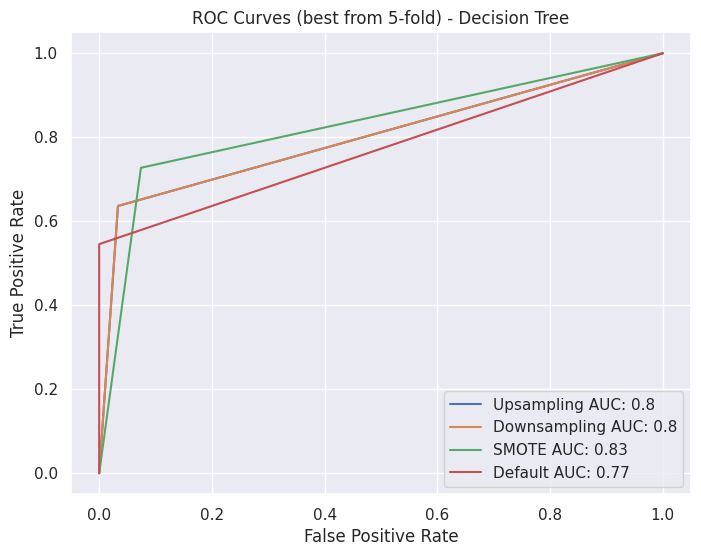

In [ ]:
plot_roc_curves(best_performing_ups_dt_model,
                best_performing_dwn_dt_model,
                best_performing_smote_dt_model,
                best_performing_default_dt_model, 'ROC Curves (best from 5-fold) - Decision Tree')

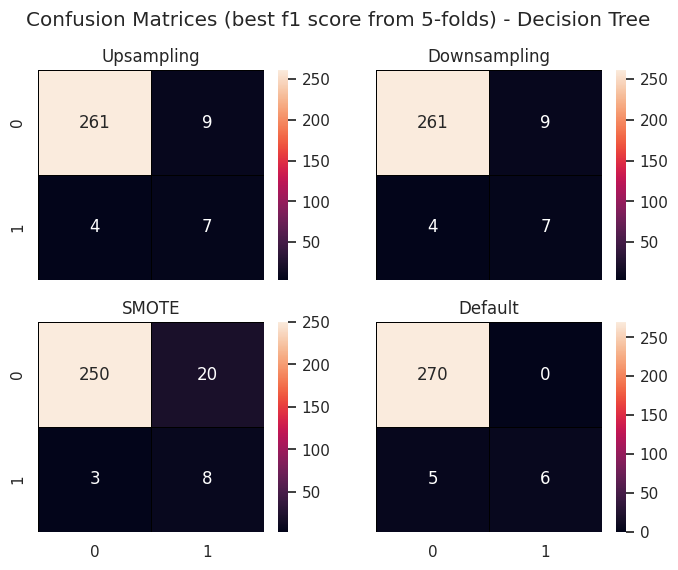

In [ ]:
plot_confusion_matrices((best_performing_ups_dt_model,
                         best_performing_dwn_dt_model,
                         best_performing_smote_dt_model,
                         best_performing_default_dt_model), 'Confusion Matrices (best f1 score from 5-folds) - Decision Tree')

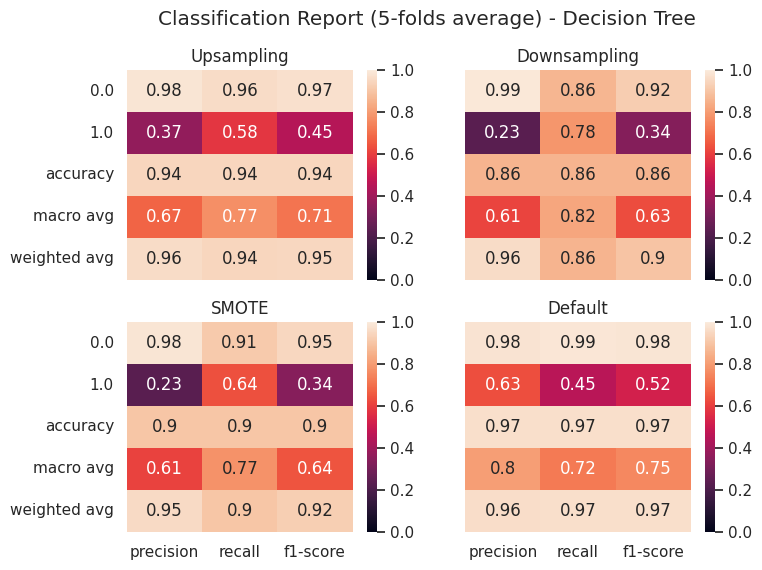

In [ ]:
plot_classification_reports_averages((reports_ups_dt,
                                      reports_dwn_dt,
                                      reports_smote_dt,
                                      reports_default_dt),'Classification Report (5-folds average) - Decision Tree')

## CNB

#### Data preparation

In [ ]:
# remove unecessesary features from dataset
# df_cnb = df_cl[['metacritic_critics', 'opening_weekend_($million)',
#                'domestic_gross_($million)', 'foreign_gross_($million)',
#                'oscar_winners']]

df_cnb  = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
                    'oscar_detail'], axis=1)

# Separate testing split from dataset
df_cnb_train, df_cnb_test = train_test_split(df_cnb, test_size=0.2, stratify=df_cnb['oscar_winners'])

# Separate classes
df_cnb_majority = df_cnb_train[(df_cnb_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
df_cnb_minority = df_cnb_train[(df_cnb_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

#### Upsample

In [ ]:
# Umpsample the minority class
df_cnb_minority_upsampled = resample(df_cnb_minority, replace=True, n_samples= len(df_cnb_majority), random_state=42)

df_cnb_minority_upsampled = df_cnb_minority_upsampled.reset_index().drop('index', axis=1)

df_cnb_upsampled = pd.concat([df_cnb_minority_upsampled, df_cnb_majority]).sort_index(kind='merge')
df_cnb_upsampled = df_cnb_upsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_cnb_upsampled.drop(['oscar_winners'], axis=1)
y = df_cnb_upsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_ups_cnb = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_cnb_upsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = ComplementNB(force_alpha=True)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_cnb_test.drop(['oscar_winners'], axis=1).values, df_cnb_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_ups_cnb.append({'label' : 'Upsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_ups_cnb_model = max(reports_ups_cnb, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9502
Fold 2 test accuracy: 0.9502
Fold 3 test accuracy: 0.9502
Fold 4 test accuracy: 0.9502
Fold 5 test accuracy: 0.9502


#### Downsample

In [ ]:
# Downsample majority class
df_cnb_majority_downsampled = resample(df_cnb_majority, replace=True, n_samples= len(df_cnb_minority), random_state=42)

df_cnb_majority_downsampled = df_cnb_majority_downsampled.reset_index().drop('index', axis=1)

df_cnb_downsampled = pd.concat([df_cnb_majority_downsampled, df_cnb_minority]).sort_index(kind='merge')
df_cnb_downsampled = df_cnb_downsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_cnb_downsampled.drop(['oscar_winners'], axis=1)
y = df_cnb_downsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_dwn_cnb = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_cnb_downsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = ComplementNB(force_alpha=True)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_cnb_test.drop(['oscar_winners'], axis=1).values, df_cnb_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_dwn_cnb.append({'label' : 'Downsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_dwn_cnb_model = max(reports_dwn_cnb, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.3167
Fold 2 test accuracy: 0.5730
Fold 3 test accuracy: 0.2242
Fold 4 test accuracy: 0.9502
Fold 5 test accuracy: 0.9502


#### SMOTE

In [ ]:
# Resample using SMOTE method
sm = SMOTE(sampling_strategy='minority', random_state=42)

df_cnb_oversampled_X, df_cnb_oversampled_Y = sm.fit_resample(df_cnb_train.drop('oscar_winners', axis=1), df_cnb_train['oscar_winners'])
df_cnb_oversampled = pd.concat([pd.DataFrame(df_cnb_oversampled_X), pd.DataFrame(df_cnb_oversampled_Y)], axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_cnb_oversampled.drop(['oscar_winners'], axis=1)
y = df_cnb_oversampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_smote_cnb = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_cnb_oversampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = ComplementNB(force_alpha=True)
    model.fit(X_train, y_train)
    
    # Test on test split
    X_test, y_test = df_cnb_test.drop(['oscar_winners'], axis=1).values, df_cnb_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_smote_cnb.append({'label' : 'SMOTE',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_smote_cnb_model = max(reports_smote_cnb, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9502
Fold 2 test accuracy: 0.9502
Fold 3 test accuracy: 0.0498
Fold 4 test accuracy: 0.9466
Fold 5 test accuracy: 0.9502


#### Default

In [ ]:
# Prepare dataset for training k-fold splits
X = df_cnb_train.drop(['oscar_winners'], axis=1)
y = df_cnb_train[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_default_cnb = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_cnb_train.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = ComplementNB(force_alpha=True)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_cnb_test.drop(['oscar_winners'], axis=1).values, df_cnb_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]    

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_default_cnb.append({'label' : 'Default',
                            'report': report,
                            'true' : y_test,
                            'preds' :y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_default_cnb_model = max(reports_default_cnb, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.5160
Fold 2 test accuracy: 0.0569
Fold 3 test accuracy: 0.0498
Fold 4 test accuracy: 0.9502
Fold 5 test accuracy: 0.9502


### Plots

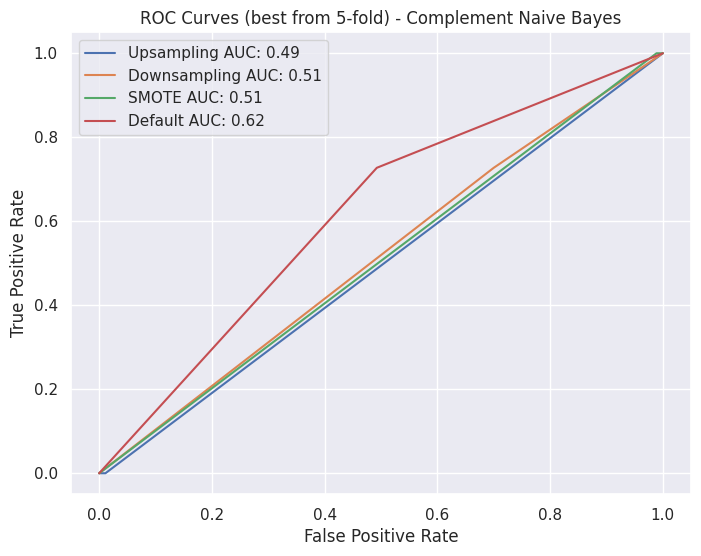

In [ ]:
plot_roc_curves(best_performing_ups_cnb_model,
                best_performing_dwn_cnb_model,
                best_performing_smote_cnb_model,
                best_performing_default_cnb_model, 
                'ROC Curves (best from 5-fold) - Complement Naive Bayes')

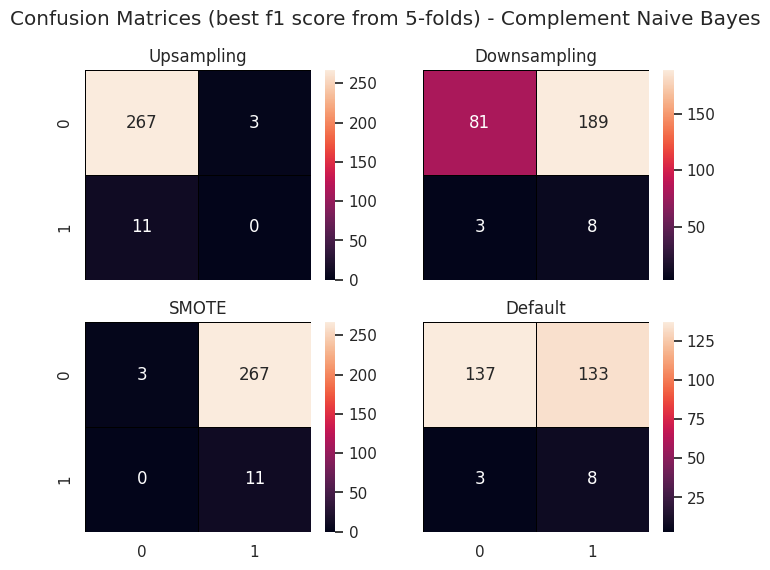

In [ ]:
plot_confusion_matrices((best_performing_ups_cnb_model,
                         best_performing_dwn_cnb_model,
                         best_performing_smote_cnb_model,
                         best_performing_default_cnb_model), 
                         'Confusion Matrices (best f1 score from 5-folds) - Complement Naive Bayes')

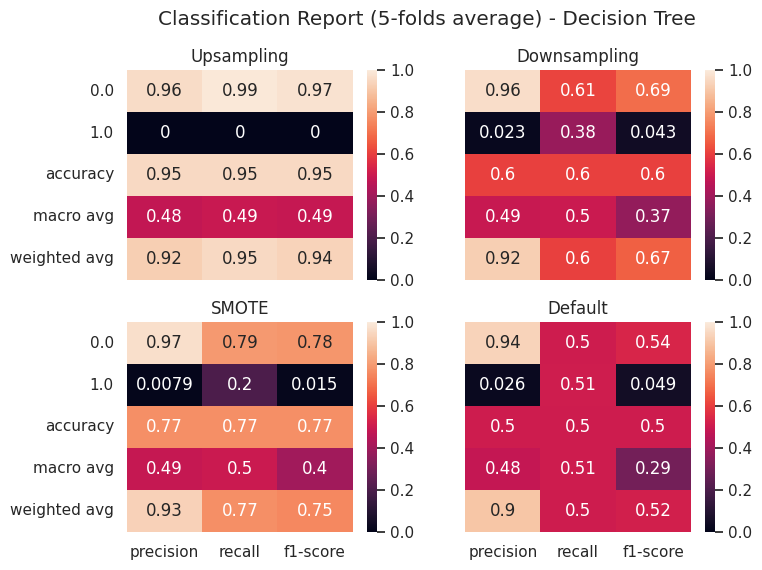

In [ ]:
plot_classification_reports_averages((reports_ups_cnb,
                                      reports_dwn_cnb,
                                      reports_smote_cnb,
                                      reports_default_cnb),
                                      'Classification Report (5-folds average) - Decision Tree')

## ADA boost

#### Data preparation

In [ ]:
# remove unecessesary features from dataset
df_ada = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
                    'oscar_detail'], axis=1)

# df_ada = df_cl[['average_audience','average_critics']]

# Separate testing split from dataset
df_ada_train, df_ada_test = train_test_split(df_ada, test_size=0.2, stratify=df_ada['oscar_winners'])

# Separate classes
df_ada_majority = df_ada_train[(df_ada_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
df_ada_minority = df_ada_train[(df_ada_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

#### Upsampling


In [ ]:
# Umpsample the minority class
df_ada_minority_upsampled = resample(df_ada_minority, replace=True, n_samples= len(df_ada_majority), random_state=42)

df_ada_minority_upsampled = df_ada_minority_upsampled.reset_index().drop('index', axis=1)

df_ada_upsampled = pd.concat([df_ada_minority_upsampled, df_ada_majority]).sort_index(kind='merge')
df_ada_upsampled = df_ada_upsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_ada_upsampled.drop(['oscar_winners'], axis=1)
y = df_ada_upsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_ups_ada = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_ada_upsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_ada_test.drop(['oscar_winners'], axis=1).values, df_ada_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_ups_ada.append({'label' : 'Upsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_ups_ada_model = max(reports_ups_ada, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9146
Fold 2 test accuracy: 0.9075
Fold 3 test accuracy: 0.8968
Fold 4 test accuracy: 0.9146
Fold 5 test accuracy: 0.9004


#### 5.3.3 Downsampling

In [ ]:
# Downsample majority class
df_ada_majority_downsampled = resample(df_ada_majority, replace=True, n_samples= len(df_ada_minority), random_state=42)

df_ada_majority_downsampled = df_ada_majority_downsampled.reset_index().drop('index', axis=1)

df_ada_downsampled = pd.concat([df_ada_majority_downsampled, df_ada_minority]).sort_index(kind='merge')
df_ada_downsampled = df_ada_downsampled.reset_index().drop('index', axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_ada_downsampled.drop(['oscar_winners'], axis=1)
y = df_ada_downsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_dwn_ada = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_ada_downsampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_ada_test.drop(['oscar_winners'], axis=1).values, df_ada_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_dwn_ada.append({'label' : 'Downsampling',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_dwn_ada_model = max(reports_dwn_ada, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.8612
Fold 2 test accuracy: 0.7331
Fold 3 test accuracy: 0.9110
Fold 4 test accuracy: 0.6868
Fold 5 test accuracy: 0.6228


#### SMOTE

In [ ]:
# Resample using SMOTE method
sm = SMOTE(sampling_strategy='minority', random_state=42)

df_ada_oversampled_X, df_ada_oversampled_Y = sm.fit_resample(df_ada_train.drop('oscar_winners', axis=1), df_ada_train['oscar_winners'])
df_ada_oversampled = pd.concat([pd.DataFrame(df_ada_oversampled_X), pd.DataFrame(df_ada_oversampled_Y)], axis=1)

In [ ]:
# Prepare dataset for training k-fold splits
X = df_ada_oversampled.drop(['oscar_winners'], axis=1)
y = df_ada_oversampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_smote_ada = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_ada_oversampled.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    
    # Test on test split
    X_test, y_test = df_ada_test.drop(['oscar_winners'], axis=1).values, df_ada_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)       
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_smote_ada.append({'label' : 'SMOTE',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_smote_ada_model = max(reports_smote_ada, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9075
Fold 2 test accuracy: 0.9395
Fold 3 test accuracy: 0.9004
Fold 4 test accuracy: 0.9253
Fold 5 test accuracy: 0.9039


#### Default

In [ ]:
# Prepare dataset for training k-fold splits
X = df_ada_train.drop(['oscar_winners'], axis=1)
y = df_ada_train[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_default_ada = []
for i, train_idx in enumerate(kf.split(X, y), 1):

    train = df_ada_train.iloc[train_idx[1]] 
    
    # Separate labels
    X_train, y_train = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
    y_train = y_train.squeeze(axis=1)

    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Test on test split
    X_test, y_test = df_ada_test.drop(['oscar_winners'], axis=1).values, df_ada_test[['oscar_winners']].values
    y_test = y_test.squeeze(axis=1)

    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Fold {i} test accuracy: {acc:.4f}")

    y_pred = [float(x) for x in y_pred]
    y_test = [float(x) for x in y_test]    

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)
    reports_default_ada.append({'label' : 'Default',
                            'report': report,
                            'true' : y_test,
                            'preds' : y_pred,
                            'X_train' : X_train,
                            'y_train' : y_train})

best_performing_default_ada_model = max(reports_default_ada, key=lambda a:a['report']['1.0']['f1-score'])

Fold 1 test accuracy: 0.9502
Fold 2 test accuracy: 0.9466
Fold 3 test accuracy: 0.9644
Fold 4 test accuracy: 0.9644
Fold 5 test accuracy: 0.9395


#### Plots

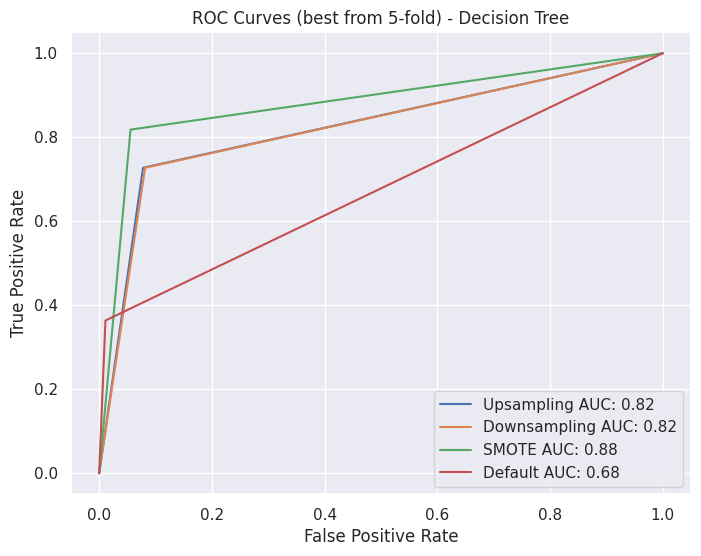

In [ ]:
plot_roc_curves(best_performing_ups_ada_model,
                best_performing_dwn_ada_model,
                best_performing_smote_ada_model,
                best_performing_default_ada_model, 
                'ROC Curves (best from 5-fold) - Decision Tree')

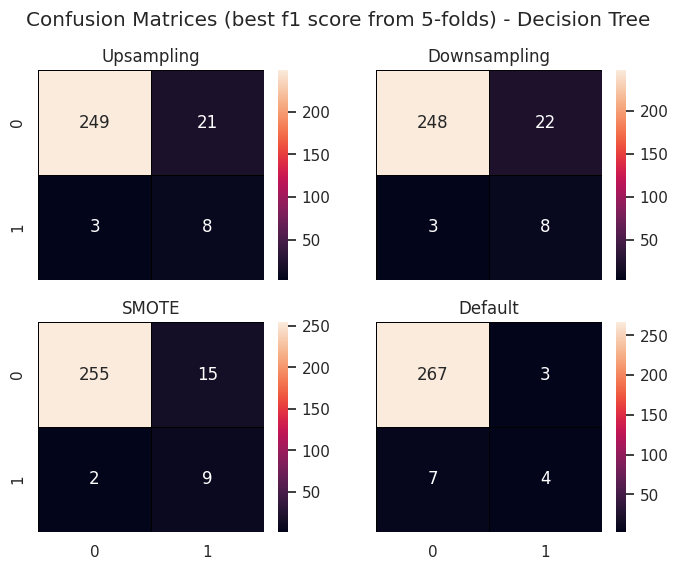

In [ ]:
plot_confusion_matrices((best_performing_ups_ada_model,
                         best_performing_dwn_ada_model,
                         best_performing_smote_ada_model,
                         best_performing_default_ada_model), 
                         'Confusion Matrices (best f1 score from 5-folds) - Decision Tree')

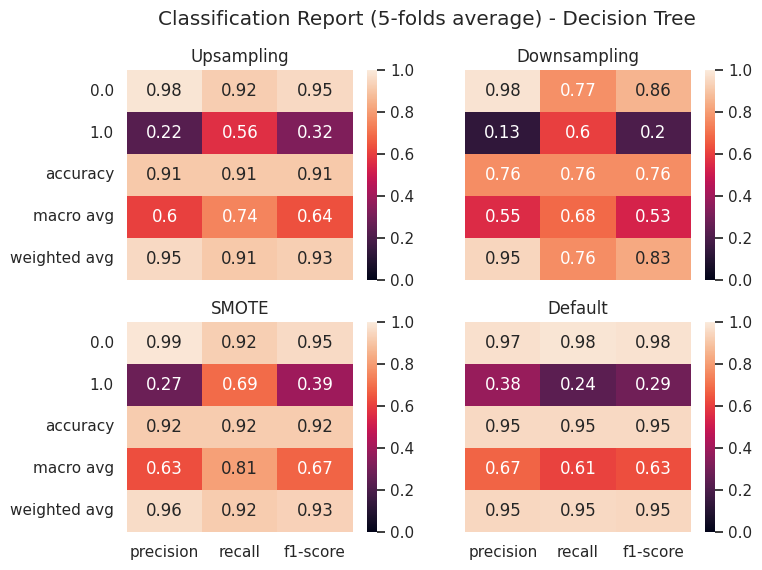

In [ ]:
plot_classification_reports_averages((reports_ups_ada,
                                      reports_dwn_ada,
                                      reports_smote_ada,
                                      reports_default_ada),
                                      'Classification Report (5-folds average) - Decision Tree')

# 6. Προβλέψεις στο άγνωστο σύνολο δεδομένων
Χρησιμοποιούμε τα εκπαιδευμένα μοντέλα κτηγοριοποίησης για να προβλέψουμε στο άγνωστο σύνολο δεδομένων αν πήραν oscar ή όχι.

## 6.1 Νευρωνικό δίκτυο

In [ ]:
# df_un_cl_nn = df_un_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
#                     'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
#                     'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)', 'oscar_winners', 'oscar_detail'], axis=1)

In [ ]:
# X = torch.tensor(df_un_cl_nn.values, dtype=torch.float)

# best_perf = [best_performing_default_nn_model, best_performing_dwn_nn_model, best_performing_ups_nn_model, best_performing_smote_nn_model]


# for model_dict in best_perf:
#     print(model_dict['label'])
#     neural_network = OscarClassificationNeuralNetwork(input_features=nn_input_features, 
#                                                         hidden_layer_input_features = nn_input_features,
#                                                         hidden_layer_output_features = nn_input_features,
#                                                         device='cpu',                                               
#                                                         learning_rate=0.01)

#     neural_network.load_state_dict(model_dict['dict'])

#     with torch.inference_mode():
#         neural_network.eval()
#         un_nn_preds = neural_network(X)

#     preds_df = pd.DataFrame(torch.round(torch.sigmoid(un_nn_preds)))

#     df_un_orig[f'Neural network {model_dict["label"]} prediction'] = preds_df

Use majority vote from models trained on different dataset sampling techniques

In [ ]:
# df_un_orig['neural network oscar predictions (majority)'] = df_un_orig.apply(lambda row: 1 if (row['Neural network Default prediction'] + row['Neural network SMOTE prediction'] + row['Neural network Downsampling prediction'] + row['Neural network Upsampling prediction'] >= 3) else 0, axis=1)

In [ ]:
# df_un_orig[df_un_orig['Neural network Default prediction'] + df_un_orig['Neural network SMOTE prediction'] + df_un_orig['Neural network Downsampling prediction'] + df_un_orig['Neural network Upsampling prediction'] >= 3]

In [ ]:
# df_un_orig = df_un_orig.drop(['Neural network Default prediction', 'Neural network SMOTE prediction', 'Neural network Downsampling prediction', 'Neural network Upsampling prediction'], axis =1)
# df_un_orig[df_un_orig['neural network oscar predictions (majority)'] == 1]

## 6.2 KNN

In [ ]:
df_un_cl_knn = df_un_cl[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'opening_weekend_($million)', 'domestic_gross_($million)',
       'foreign_gross_($million)', 'budget_($million)']]

X = df_un_cl_knn.values
best_knn_models = [best_performing_default_knn_model, best_performing_dwn_knn_model, best_performing_ups_knn_model, best_performing_smote_knn_model]

In [ ]:
# for model_dict in best_knn_models:
#     # print(model_dict)
#     knn = KNeighborsClassifier(n_neighbors=model_dict['best_k'])
#     knn.fit(model_dict['X_train'], model_dict['y_train'])

#     un_knn_preds = knn.predict(X)

#     preds_df = pd.DataFrame(un_knn_preds)

#     df_un_orig[f'KNN {model_dict["label"]} prediction'] = preds_df

In [ ]:
best_performing_knn_model = max(best_knn_models, key=lambda a:a['report']['1.0']['f1-score'])

knn = KNeighborsClassifier(n_neighbors=best_performing_knn_model['best_k'])
knn.fit(best_performing_knn_model['X_train'], best_performing_knn_model['y_train'])

un_knn_preds = knn.predict(X)

preds_df = pd.DataFrame(un_knn_preds)

df_un_orig[f'KNN'] = preds_df

In [ ]:
len(df_un_orig[df_un_orig['KNN'] == 1])

87

In [ ]:
# df_un_orig['KNN oscar predictions (majority)'] = df_un_orig.apply(lambda row: 1 if (row['KNN Default prediction'] + 
#                                                                                                row['KNN SMOTE prediction'] + 
#                                                                                                row['KNN Downsampling prediction'] + 
#                                                                                                row['KNN Upsampling prediction'] >= 3)
#                                                                                              else 0, axis=1)

In [ ]:
# df_un_orig = df_un_orig.drop(['KNN Default prediction',
#                               'KNN SMOTE prediction',
#                               'KNN Downsampling prediction',
#                               'KNN Upsampling prediction'], axis =1)

# df_un_orig[df_un_orig['KNN oscar predictions (majority)'] == 1]

## 6.3 Decision Tree

In [ ]:
df_un_cl_dt = df_un_cl[['metacritic_critics', 'opening_weekend_($million)',
               'domestic_gross_($million)', 'foreign_gross_($million)']]

X = df_un_cl_dt.values
best_dt_models = [best_performing_default_dt_model, best_performing_dwn_dt_model, best_performing_ups_dt_model, best_performing_smote_dt_model]

In [ ]:
# X = df_un_cl_dt.values

# best_perf = [best_performing_default_dt_model, best_performing_dwn_dt_model, best_performing_ups_dt_model, best_performing_smote_dt_model]

# for model_dict in best_perf:

#     dt = DecisionTreeClassifier(criterion='gini', splitter='best')
#     dt.fit(model_dict['X_train'], model_dict['y_train'])

#     un_dt_preds = dt.predict(X)

#     preds_df = pd.DataFrame(un_dt_preds)

#     df_un_orig[f'DT {model_dict["label"]} prediction'] = preds_df

In [ ]:
best_performing_dt_model = max(best_dt_models, key=lambda a:a['report']['1.0']['f1-score'])

dt = DecisionTreeClassifier(criterion='gini', splitter='best')
dt.fit(best_performing_dt_model['X_train'], best_performing_dt_model['y_train'])

un_dt_preds = dt.predict(X)

preds_df = pd.DataFrame(un_dt_preds)

df_un_orig['DT'] = preds_df

In [ ]:
len(df_un_orig[df_un_orig['DT'] == 1])

20

In [ ]:
# df_un_orig['DT oscar predictions (majority)'] = df_un_orig.apply(lambda row: 1 if (row['DT Default prediction'] + 
#                                                                                                row['DT SMOTE prediction'] + 
#                                                                                                row['DT Downsampling prediction'] + 
#                                                                                                row['DT Upsampling prediction'] >= 3)
#                                                                                              else 0, axis=1)

In [ ]:
# df_un_orig = df_un_orig.drop(['DT Default prediction',
#                               'DT SMOTE prediction',
#                               'DT Downsampling prediction',
#                               'DT Upsampling prediction'], axis =1)

# df_un_orig[df_un_orig['DT oscar predictions (majority)'] == 1]

## 6.4 CNB

In [ ]:
len(X[0])

43

In [ ]:
df_un_cl_cnb  = df_un_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
                    'oscar_detail', 'oscar_winners'], axis=1)

X = df_un_cl_cnb.values
best_cnb_models = [best_performing_default_cnb_model, best_performing_dwn_cnb_model, best_performing_ups_cnb_model, best_performing_smote_cnb_model]

In [ ]:
best_performing_cnb_model = max(best_cnb_models, key=lambda a:a['report']['1.0']['f1-score'])

cnb = ComplementNB(force_alpha=True)
cnb.fit(best_performing_cnb_model['X_train'], best_performing_cnb_model['y_train'])

un_cnb_preds = cnb.predict(X)

preds_df = pd.DataFrame(un_cnb_preds)

df_un_orig['CNB'] = preds_df

In [ ]:
len(df_un_orig[df_un_orig['CNB'] == 1])

267

## 6.5 ADA Boost

In [ ]:
df_un_cl_ada  = df_un_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
                    'oscar_detail', 'oscar_winners'], axis=1)

X = df_un_cl_ada.values
best_ada_models = [best_performing_default_ada_model, best_performing_dwn_ada_model, best_performing_ups_ada_model, best_performing_smote_ada_model]

In [ ]:
best_performing_cnb_model = max(best_cnb_models, key=lambda a:a['report']['1.0']['f1-score'])

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(best_performing_cnb_model['X_train'], best_performing_cnb_model['y_train'])

un_ada_preds = ada.predict(X)

preds_df = pd.DataFrame(un_ada_preds)

df_un_orig['ADA'] = preds_df

In [ ]:
len(df_un_orig[df_un_orig['ADA'] == 1])

24

## 6.4 Final predictions

In [ ]:
predictions = df_un_orig[['ID', 'KNN', 'DT', 'CNB', 'ADA']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['KNN'] + row['DT'] + row['CNB'] + row['ADA'] >= 3) else 0, axis=1)
# predictions = predictions.drop(['KNN', 'DT oscar predictions (majority)'], axis=1)

/tmp/ipykernel_22703/1202308436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['KNN'] + row['DT'] + row['CNB'] + row['ADA'] >= 3) else 0, axis=1)


In [ ]:
len(predictions[predictions['OSCAR'] == 1])

11

In [ ]:
print(f"Unkn dataset oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / 560 * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset oscar ratio: 1.96% | Testing dataset oscar prediction ratio: 3.99%


In [ ]:
# Save file
# predictions.to_csv('./predictions.csv', index=False)